# Imports and installations

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from google.colab import drive

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

In [2]:
drive.mount("/content/drive", force_remount=True)
%cd /content/drive/My\ Drive/challenge-bain

Mounted at /content/drive
/content/drive/My Drive/challenge-bain


In [3]:
!ls

df_model_filled.csv		    flux_with_sliding_regions_precip.csv
flux.csv			    flux_with_sliding_regions_temp.csv
flux_with_sliding_flux.csv	    flux_with_sliding_temp.csv
flux_with_sliding_precip.csv	    watershed_challenge.ipynb
flux_with_sliding_regions_flux.csv


# Reading the data

In [4]:
df = pd.read_csv("flux.csv")
df.head()

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2
0,1980-01-01,1001001,0.579,0.0,10.685653,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
1,1980-01-02,1001001,0.543,0.0,11.470960,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
2,1980-01-03,1001001,0.482,0.0,11.947457,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
3,1980-01-04,1001001,0.459,0.0,12.424489,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
4,1980-01-05,1001001,0.436,0.0,12.649203,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859


Analyzing data types:

In [5]:
df.dtypes

date           object
basin_id        int64
flux          float64
precip        float64
temp_max      float64
gauge_name     object
lat           float64
lon           float64
mean_elev     float64
area_km2      float64
dtype: object

Some of them were incorrectly inferred, let's fix them.

In [6]:
df = pd.read_csv("flux.csv", infer_datetime_format=True, parse_dates=['date'], dtype={"basin_id": "str"})

In [7]:
df.dtypes

date          datetime64[ns]
basin_id              object
flux                 float64
precip               float64
temp_max             float64
gauge_name            object
lat                  float64
lon                  float64
mean_elev            float64
area_km2             float64
dtype: object

# Analyzing the data

## Data types

In [8]:
desc = df.describe(include='all')
desc

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2
count,4180480,4180480,4.180480e+06,4.175037e+06,4.175037e+06,4180480,4.180480e+06,4.180480e+06,4.180480e+06,4.180480e+06
unique,14768,503,NaN,NaN,NaN,503,NaN,NaN,NaN,NaN
top,2013-11-01 00:00:00,5410002,NaN,NaN,NaN,Rio Aconcagua En Chacabuquito,NaN,NaN,NaN,NaN
freq,366,14670,NaN,NaN,NaN,14670,NaN,NaN,NaN,NaN
first,1980-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-06-06 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,5.253340e+01,2.947445e+00,1.365728e+01,NaN,-3.569572e+01,-7.129595e+01,1.760129e+03,2.404876e+03
std,NaN,NaN,1.676027e+02,8.766749e+00,6.615037e+00,NaN,8.047659e+00,1.254339e+00,1.382121e+03,4.322051e+03
min,NaN,NaN,0.000000e+00,0.000000e+00,-1.160359e+01,NaN,-5.494690e+01,-7.366670e+01,1.181229e+02,1.789123e+01
25%,NaN,NaN,8.680000e-01,0.000000e+00,9.162867e+00,NaN,-3.915000e+01,-7.231670e+01,5.847012e+02,3.761001e+02


In [9]:
print("The range of date is: {min_date} to {max_date}".format(min_date = min(df.date), max_date = max(df.date)))
print("There are {} different stations".format(desc['basin_id'].loc['unique']))
print("There are {} records from station {}".format(desc['basin_id'].loc['freq'], desc['basin_id'].loc['top']))

The range of date is: 1980-01-01 00:00:00 to 2020-06-06 00:00:00
There are 503 different stations
There are 14670 records from station 5410002


## Null data

In [10]:
df.isna().sum()

date             0
basin_id         0
flux             0
precip        5443
temp_max      5443
gauge_name       0
lat              0
lon              0
mean_elev        0
area_km2         0
dtype: int64

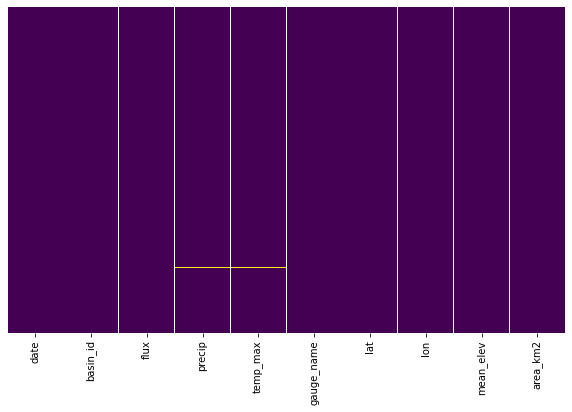

In [11]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), yticklabels=False, cmap='viridis', cbar=False);

In [12]:
null = df[df.precip.isna() == True]
len(null.basin_id.unique())

174

In [13]:
null[null.basin_id == "1021001"].sort_values(by='date')

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2
60493,2020-05-06,1021001,1.707,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60494,2020-05-07,1021001,1.687,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60495,2020-05-08,1021001,1.698,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60496,2020-05-09,1021001,1.694,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60497,2020-05-10,1021001,1.690,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60498,2020-05-11,1021001,1.644,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60499,2020-05-12,1021001,1.622,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60500,2020-05-13,1021001,1.624,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60501,2020-05-14,1021001,1.622,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60502,2020-05-15,1021001,1.606,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908


In [14]:
null[null.basin_id == "1021002"].sort_values(by='date')

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2
73924,2020-05-06,1021002,0.279,NaN,NaN,Rio Guallatire En Guallatire,-18.4931,-69.1494,4613.118793,49.69925
73925,2020-05-07,1021002,0.279,NaN,NaN,Rio Guallatire En Guallatire,-18.4931,-69.1494,4613.118793,49.69925
73926,2020-05-08,1021002,0.279,NaN,NaN,Rio Guallatire En Guallatire,-18.4931,-69.1494,4613.118793,49.69925
73927,2020-05-09,1021002,0.279,NaN,NaN,Rio Guallatire En Guallatire,-18.4931,-69.1494,4613.118793,49.69925
73928,2020-05-10,1021002,0.279,NaN,NaN,Rio Guallatire En Guallatire,-18.4931,-69.1494,4613.118793,49.69925
73929,2020-05-11,1021002,0.279,NaN,NaN,Rio Guallatire En Guallatire,-18.4931,-69.1494,4613.118793,49.69925
73930,2020-05-12,1021002,0.279,NaN,NaN,Rio Guallatire En Guallatire,-18.4931,-69.1494,4613.118793,49.69925
73931,2020-05-13,1021002,0.279,NaN,NaN,Rio Guallatire En Guallatire,-18.4931,-69.1494,4613.118793,49.69925
73932,2020-05-14,1021002,0.279,NaN,NaN,Rio Guallatire En Guallatire,-18.4931,-69.1494,4613.118793,49.69925
73933,2020-05-15,1021002,0.279,NaN,NaN,Rio Guallatire En Guallatire,-18.4931,-69.1494,4613.118793,49.69925


In [15]:
print("Records are missing for {} stations from {} to {}. \nTo see if we can fill this data, we can investigate data from near stations.".format(len(null.basin_id.unique()), null.date.min(), null.date.max()))

Records are missing for 174 stations from 2020-05-01 00:00:00 to 2020-06-06 00:00:00. 
To see if we can fill this data, we can investigate data from near stations.


Grouping data by station:

In [16]:
stations = df.groupby(by=['basin_id', 'gauge_name', 'lat', 'lon']).agg({
    "date": lambda x: max(x),
    "flux": "mean",
    "precip": "mean",
    "temp_max": "mean",
    "mean_elev": "mean",
    'area_km2': "mean"
})
stations.reset_index(inplace=True)
stations

,basin_id,gauge_name,lat,lon,date,flux,precip,temp_max,mean_elev,area_km2
0,1001001,Rio Caquena En Nacimiento,-18.0769,-69.1961,2004-05-25,0.447502,1.247240,9.250165,4842.449328,49.711859
1,1001002,Rio Caquena En Vertedero,-17.9942,-69.2550,2019-12-31,1.145109,1.122074,10.079816,4652.603986,467.556222
2,1001003,Rio Colpacagua En Desembocadura,-18.0156,-69.2308,2019-06-30,0.221237,1.315032,9.668089,4774.097286,198.808235
3,10100002,Rio Fui En Desage Lago Pirihueico,-39.8747,-71.8897,2019-06-30,67.005102,6.561018,13.128364,1171.120701,1498.526292
4,10100006,Rio Huahum En La Frontera,-40.0967,-71.6758,2019-08-31,52.472140,6.494451,13.257002,1194.828698,1029.147578
...,...,...,...,...,...,...,...,...,...,...
498,9423001,Rio Tolten En Coipue,-39.1000,-72.3833,2020-05-20,280.558219,7.457114,15.040499,879.462289,3489.585890
499,9433001,Rio Puyehue En Quitratue,-39.1500,-72.6667,2019-08-31,6.463415,4.960193,18.038811,200.348841,153.455864
500,9434001,Rio Donguil En Gorbea,-39.1000,-72.6833,2019-08-31,31.136553,5.014636,18.151290,206.213494,769.734358
501,9436001,Rio Mahuidanche En Santa Ana,-39.0833,-72.9333,2019-09-05,17.580840,4.740311,17.870803,189.026330,383.889999


Grouping null data by station:

In [17]:
null_grouped = null.groupby(by=['basin_id', 'gauge_name', 'lat', 'lon']).agg({
    "date": lambda x: max(x),
    "flux": "mean",
    "mean_elev": "mean",
    'area_km2': "mean"
})
null_grouped.reset_index(inplace=True)
null_grouped

,basin_id,gauge_name,lat,lon,date,flux,mean_elev,area_km2
0,10122003,Rio Calle Calle En Pupunahue,-39.8044,-72.9025,2020-06-06,233.083125,693.879737,6495.171392
1,10133000,Rio Leufucade En Purulon,-39.4781,-72.6908,2020-06-06,5.879719,292.364409,553.195357
2,10134001,Rio Cruces En Rucaco,-39.5500,-72.9000,2020-06-06,20.658344,281.881918,1802.603753
3,1021001,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,2020-06-06,1.633813,4493.855498,3277.980908
4,1021002,Rio Guallatire En Guallatire,-18.4931,-69.1494,2020-06-06,0.279000,4613.118793,49.699250
...,...,...,...,...,...,...,...,...
169,9129002,Rio Cautin En Cajon,-38.6867,-72.5028,2020-06-06,35.727562,762.685107,2755.565846
170,9140001,Rio Cautin En Almagro,-38.7800,-72.9469,2020-06-06,92.250250,552.694442,5547.328745
171,9412001,Rio Trancura En Curarrehue,-39.3600,-71.5808,2020-06-06,18.614750,1195.311142,356.917642
172,9423001,Rio Tolten En Coipue,-39.1000,-72.3833,2020-05-20,107.803333,879.462289,3489.585890


The names of stations seem to follow a pattern. Let's see if we can separate them by regions using their names' patterns.

In [18]:
stations_list = df.basin_id.unique()
stations_list.sort()

stations1 = []
stations2 = []
stations3 = []
stations4 = []
stations5 = []
stations6 = []
stations7 = []
stations8 = []
stations9 = []
stations10 = []
stations11 = []
stations12 = []
stations_total = []

stations_other = []
for i in stations_list:
  if i[0] == "1" and len(i) <= 7:
    stations1.append(i)
    stations_total.append(i)
  elif i[0] == "2" and len(i) <= 7:
    stations2.append(i)
    stations_total.append(i)
  elif i[0] == "3" and len(i) <= 7:
    stations3.append(i)
    stations_total.append(i)
  elif i[0] == "4" and len(i) <= 7:
    stations4.append(i)
    stations_total.append(i)
  elif i[0] == "5" and len(i) <= 7:
    stations5.append(i)
    stations_total.append(i)
  elif i[0] == "6" and len(i) <= 7:
    stations6.append(i)
    stations_total.append(i)
  elif i[0] == "7" and len(i) <= 7:
    stations7.append(i)
    stations_total.append(i)
  elif i[0] == "8" and len(i) <= 7:
    stations8.append(i)
    stations_total.append(i)
  elif i[0] == "9" and len(i) <= 7:
    stations9.append(i)
    stations_total.append(i)
  elif i[0:2] == "10" and len(i) > 7:
    stations10.append(i)
    stations_total.append(i)
  elif i[0:2] == "11" and len(i) > 7:
    stations11.append(i)
    stations_total.append(i)
  elif i[0:2] == "12" and len(i) > 7:
    stations12.append(i)
    stations_total.append(i)
  else:
    stations_other.append(i)
    stations_total.append(i)

regions_list = []
regions_list.append(stations1)
regions_list.append(stations2)
regions_list.append(stations3)
regions_list.append(stations4)
regions_list.append(stations5)
regions_list.append(stations6)
regions_list.append(stations7)
regions_list.append(stations8)
regions_list.append(stations9)
regions_list.append(stations10)
regions_list.append(stations11)
regions_list.append(stations12)

print("stations1", stations1)
print("stations2", stations2)
print("stations3", stations3)
print("stations4", stations4)
print("stations5", stations5)
print("stations6", stations6)
print("stations7", stations7)
print("stations8", stations8)
print("stations9", stations9)
print("stations10", stations10)
print("stations11", stations11)
print("stations12", stations12)
print("stations_other", stations_other)
print("Number of stations {} matches sum of separated stations {}: {}".format(len(stations_list), len(stations_total), len(stations_list) == len(stations_total)))
print("Number of regions is {}".format(len(regions_list)))

stations1 ['1001001', '1001002', '1001003', '1020002', '1020003', '1021001', '1021002', '1041002', '1044001', '1050002', '1050004', '1201001', '1201003', '1201005', '1210001', '1211001', '1300009', '1310002', '1410004', '1502002', '1502008', '1610002', '1610004', '1730001', '1730002', '1730003', '1730007', '1730012']
stations2 ['2101001', '2103001', '2103002', '2103003', '2103014', '2104002', '2104003', '2104013', '2105001', '2105002', '2105005', '2105007', '2110001', '2110002', '2110004', '2110031', '2112005', '2112006', '2112007', '2113001', '2120001', '2510001']
stations3 ['3022001', '3041001', '3041002', '3041003', '3041004', '3041005', '3050001', '3404001', '3414001', '3421001', '3430001', '3430002', '3430003', '3431001', '3434001', '3434003', '3450001', '3453001', '3802001', '3804002', '3806001', '3814001', '3814003', '3815001', '3815002', '3820001', '3820002', '3820003', '3825001', '3826001']
stations4 ['4301002', '4302001', '4306001', '4308001', '4311001', '4313001', '4314001',

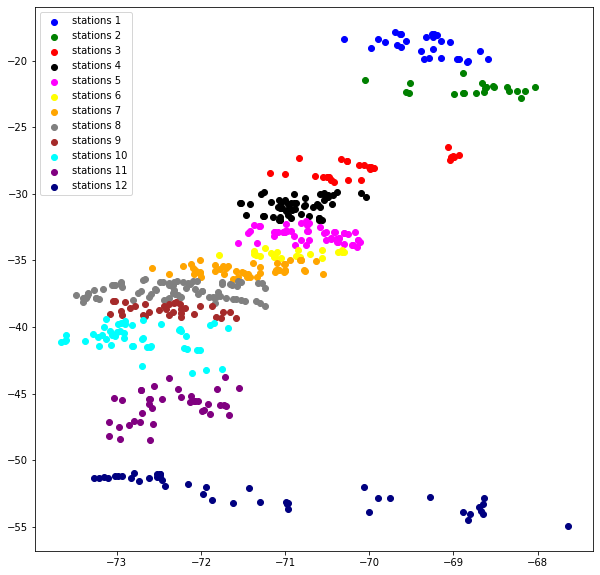

In [19]:
plt.figure(figsize=(10,10))
plt.scatter(stations[stations.basin_id.isin(stations1)].lon, stations[stations.basin_id.isin(stations1)].lat, c='b', label='stations 1')
plt.scatter(stations[stations.basin_id.isin(stations2)].lon, stations[stations.basin_id.isin(stations2)].lat, c='g', label='stations 2')
plt.scatter(stations[stations.basin_id.isin(stations3)].lon, stations[stations.basin_id.isin(stations3)].lat, c='r', label='stations 3')
plt.scatter(stations[stations.basin_id.isin(stations4)].lon, stations[stations.basin_id.isin(stations4)].lat, c='black', label='stations 4')
plt.scatter(stations[stations.basin_id.isin(stations5)].lon, stations[stations.basin_id.isin(stations5)].lat, c='magenta', label='stations 5')
plt.scatter(stations[stations.basin_id.isin(stations6)].lon, stations[stations.basin_id.isin(stations6)].lat, c='yellow', label='stations 6')
plt.scatter(stations[stations.basin_id.isin(stations7)].lon, stations[stations.basin_id.isin(stations7)].lat, c='orange', label='stations 7')
plt.scatter(stations[stations.basin_id.isin(stations8)].lon, stations[stations.basin_id.isin(stations8)].lat, c='gray', label='stations 8')
plt.scatter(stations[stations.basin_id.isin(stations9)].lon, stations[stations.basin_id.isin(stations9)].lat, c='brown', label='stations 9')
plt.scatter(stations[stations.basin_id.isin(stations10)].lon, stations[stations.basin_id.isin(stations10)].lat, c='cyan', label='stations 10')
plt.scatter(stations[stations.basin_id.isin(stations11)].lon, stations[stations.basin_id.isin(stations11)].lat, c='purple', label='stations 11')
plt.scatter(stations[stations.basin_id.isin(stations12)].lon, stations[stations.basin_id.isin(stations12)].lat, c='navy', label='stations 12')
plt.legend()

It seems reasonable, as a first approach, to follow this classification for regions. As a second and more advanced approach, we could use a clustering model, using the given atmospheric features to separate the stations in regions, depending on the climate similarities.

Let's see where the stations with null values are

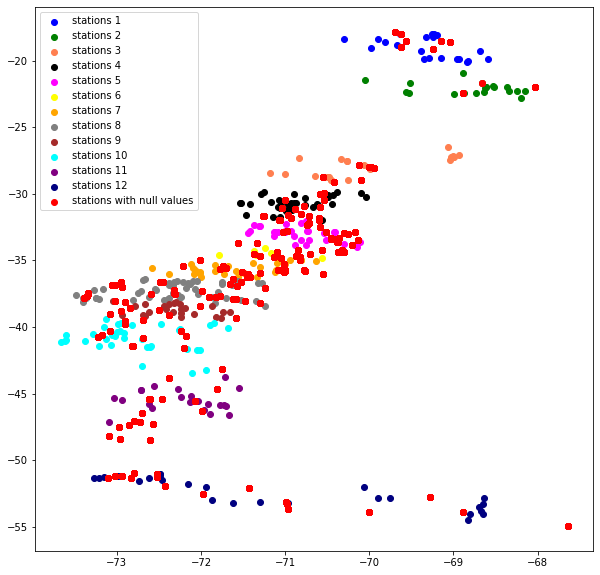

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(stations[stations.basin_id.isin(stations1)].lon, stations[stations.basin_id.isin(stations1)].lat, c='b', label='stations 1')
plt.scatter(stations[stations.basin_id.isin(stations2)].lon, stations[stations.basin_id.isin(stations2)].lat, c='g', label='stations 2')
plt.scatter(stations[stations.basin_id.isin(stations3)].lon, stations[stations.basin_id.isin(stations3)].lat, c='coral', label='stations 3')
plt.scatter(stations[stations.basin_id.isin(stations4)].lon, stations[stations.basin_id.isin(stations4)].lat, c='black', label='stations 4')
plt.scatter(stations[stations.basin_id.isin(stations5)].lon, stations[stations.basin_id.isin(stations5)].lat, c='magenta', label='stations 5')
plt.scatter(stations[stations.basin_id.isin(stations6)].lon, stations[stations.basin_id.isin(stations6)].lat, c='yellow', label='stations 6')
plt.scatter(stations[stations.basin_id.isin(stations7)].lon, stations[stations.basin_id.isin(stations7)].lat, c='orange', label='stations 7')
plt.scatter(stations[stations.basin_id.isin(stations8)].lon, stations[stations.basin_id.isin(stations8)].lat, c='gray', label='stations 8')
plt.scatter(stations[stations.basin_id.isin(stations9)].lon, stations[stations.basin_id.isin(stations9)].lat, c='brown', label='stations 9')
plt.scatter(stations[stations.basin_id.isin(stations10)].lon, stations[stations.basin_id.isin(stations10)].lat, c='cyan', label='stations 10')
plt.scatter(stations[stations.basin_id.isin(stations11)].lon, stations[stations.basin_id.isin(stations11)].lat, c='purple', label='stations 11')
plt.scatter(stations[stations.basin_id.isin(stations12)].lon, stations[stations.basin_id.isin(stations12)].lat, c='navy', label='stations 12')
plt.scatter(null.lon, null.lat, c='red', label='stations with null values')
plt.legend()

It seems reasonable, as a first approach and since I am going to group the values of the stations in the same region, to drop the values from the ones with missing data. As a second approach, I would fill those values with an average value among the four nearest stations for each date and station being analyzed.

In [21]:
df_notnull = df[df.basin_id.isin(null.basin_id.unique()) == False]
len(df_notnull.basin_id.unique())

329

## Grouping data by regions

In [22]:
def define_region(station):
  region_of_station = []
  for index, region in enumerate(regions_list):
    if station in region:
      return index+1
  
df_notnull['region'] = df_notnull.basin_id.apply(define_region)
df_notnull

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2,region
0,1980-01-01,1001001,0.579,0.000000,10.685653,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,1
1,1980-01-02,1001001,0.543,0.000000,11.470960,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,1
2,1980-01-03,1001001,0.482,0.000000,11.947457,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,1
3,1980-01-04,1001001,0.459,0.000000,12.424489,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,1
4,1980-01-05,1001001,0.436,0.000000,12.649203,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,1
...,...,...,...,...,...,...,...,...,...,...,...
4174880,2019-02-24,12878001,0.702,0.000000,9.068687,Rio Rasmussen En Frontera (Estancia VicuÑA),-54.0181,-68.6528,307.684261,468.926214,12
4174881,2019-02-25,12878001,0.625,0.000000,11.828078,Rio Rasmussen En Frontera (Estancia VicuÑA),-54.0181,-68.6528,307.684261,468.926214,12
4174882,2019-02-26,12878001,0.586,0.000000,12.532197,Rio Rasmussen En Frontera (Estancia VicuÑA),-54.0181,-68.6528,307.684261,468.926214,12
4174883,2019-02-27,12878001,0.529,0.000000,14.424746,Rio Rasmussen En Frontera (Estancia VicuÑA),-54.0181,-68.6528,307.684261,468.926214,12


In [23]:
df_regions = df_notnull.groupby(by=['region', 'date']).mean()
df_regions.reset_index(inplace=True)
df_regions

,region,date,flux,precip,temp_max,lat,lon,mean_elev,area_km2
0,1,1980-01-01,0.5616,0.000000,11.345810,-19.05554,-69.1260,4447.445505,324.888459
1,1,1980-01-02,0.4748,0.000000,12.137721,-19.05554,-69.1260,4447.445505,324.888459
2,1,1980-01-03,0.4016,0.000000,12.221334,-19.05554,-69.1260,4447.445505,324.888459
3,1,1980-01-04,0.3610,0.000000,13.022611,-19.05554,-69.1260,4447.445505,324.888459
4,1,1980-01-05,0.3372,0.000000,13.119513,-19.05554,-69.1260,4447.445505,324.888459
...,...,...,...,...,...,...,...,...,...
174817,12,2020-01-29,91.7530,4.250836,12.202825,-52.03000,-71.9414,414.643662,504.448138
174818,12,2020-01-30,91.7530,0.043187,13.102785,-52.03000,-71.9414,414.643662,504.448138
174819,12,2020-01-31,91.7530,3.921217,14.015178,-52.03000,-71.9414,414.643662,504.448138
174820,12,2020-02-01,91.7530,4.656228,14.260235,-52.03000,-71.9414,414.643662,504.448138


In [24]:
# this cell was just an ongoing idea
'''def find_nearest_stations_data(station_id, date):
  lat = stations[stations.basin_id == station_id]['lat'].values[0]
  lon = stations[stations.basin_id == station_id]['lon'].values[0]

  plt.figure(figsize=(8,8))
  plt.scatter(stations.lon, stations.lat, c='blue')
  plt.scatter(lon, lat, c='red')

  df_distances = stations[['basin_id', 'lat', 'lon']]
  df_distances['lat_diff'] = (lat - df_distances.lat)**2
  df_distances['lon_diff'] = (lon - df_distances.lon)**2
  df_distances['distance'] = df_distances[['lat_diff', 'lon_diff']].apply(lambda x: math.sqrt(x['lat_diff'] + x['lon_diff']), axis=1)
  df_distances.sort_values('distance', inplace=True)
  df_distances.reset_index(inplace=True)
  df_distances = df_distances[0:4]
  print(df_distances)

  filtered_data = df[df.basin_id in list(df_distances.basin_id)][df.date == date]
  print(filtered_data)

find_nearest_stations_data("1021001", "2020-06-06")'''

'def find_nearest_stations_data(station_id, date):\n  lat = stations[stations.basin_id == station_id][\'lat\'].values[0]\n  lon = stations[stations.basin_id == station_id][\'lon\'].values[0]\n\n  plt.figure(figsize=(8,8))\n  plt.scatter(stations.lon, stations.lat, c=\'blue\')\n  plt.scatter(lon, lat, c=\'red\')\n\n  df_distances = stations[[\'basin_id\', \'lat\', \'lon\']]\n  df_distances[\'lat_diff\'] = (lat - df_distances.lat)**2\n  df_distances[\'lon_diff\'] = (lon - df_distances.lon)**2\n  df_distances[\'distance\'] = df_distances[[\'lat_diff\', \'lon_diff\']].apply(lambda x: math.sqrt(x[\'lat_diff\'] + x[\'lon_diff\']), axis=1)\n  df_distances.sort_values(\'distance\', inplace=True)\n  df_distances.reset_index(inplace=True)\n  df_distances = df_distances[0:4]\n  print(df_distances)\n\n  filtered_data = df[df.basin_id in list(df_distances.basin_id)][df.date == date]\n  print(filtered_data)\n\nfind_nearest_stations_data("1021001", "2020-06-06")'

## Visualizing Data

### Function plot_one_timeserie()

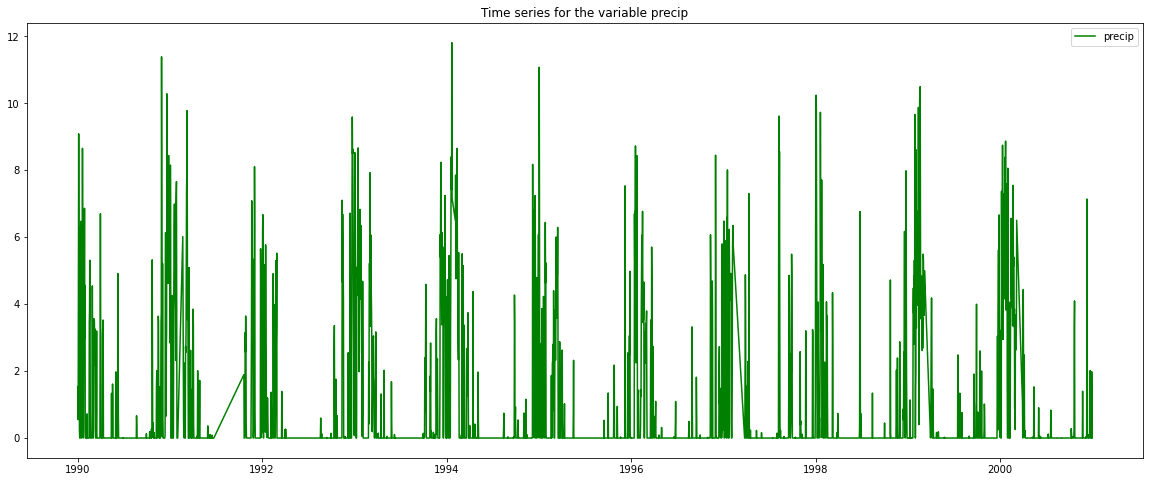

In [25]:
def plot_one_timeserie(cod_station, variable, min_date, max_date):
  df_filt = df[df.basin_id == cod_station][df.date >= min_date][df.date <= max_date][['date', variable]]
  plt.figure(figsize=(20,8))
  plt.plot(df_filt.date, df_filt[variable], 'g', label=variable)
  plt.title("Time series for the variable {}".format(variable))
  plt.legend()

plot_one_timeserie("1021001", "precip", "1990-01-01", "2000-12-30")

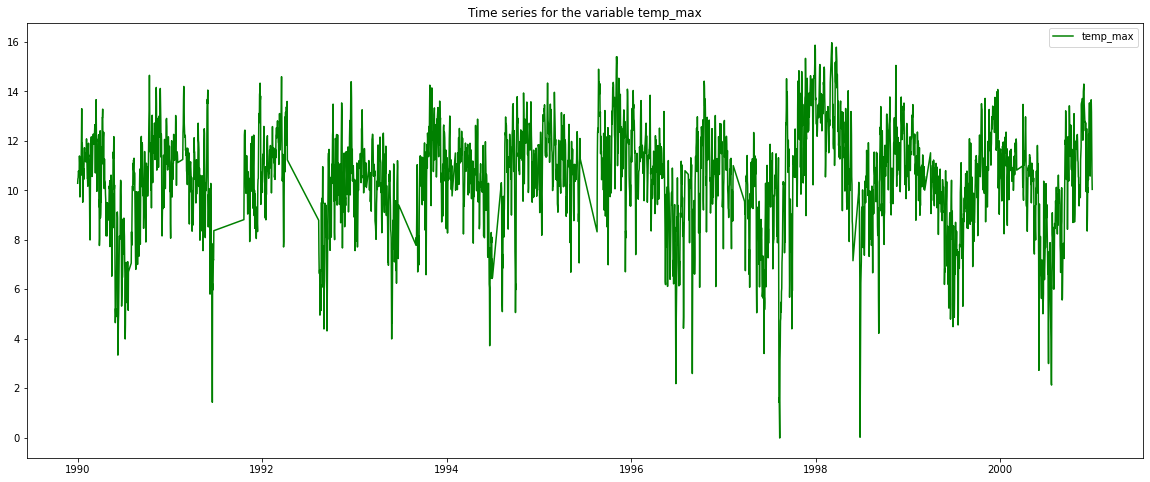

In [26]:
plot_one_timeserie("1021001", "temp_max", "1990-01-01", "2000-12-30")

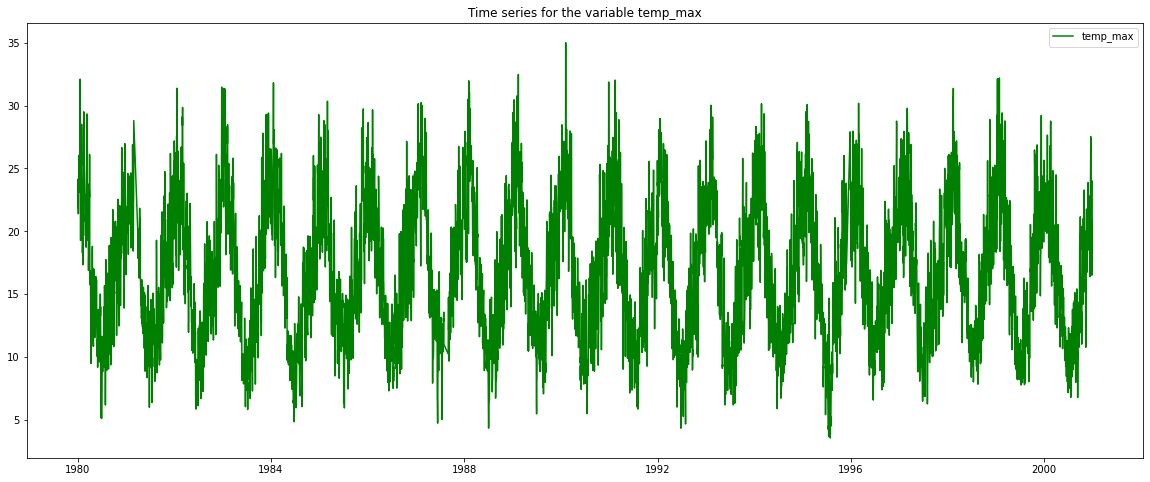

In [27]:
plot_one_timeserie("9140001", "temp_max", "1980-01-01", "2000-12-30")

### Function plot_three_timeseries()

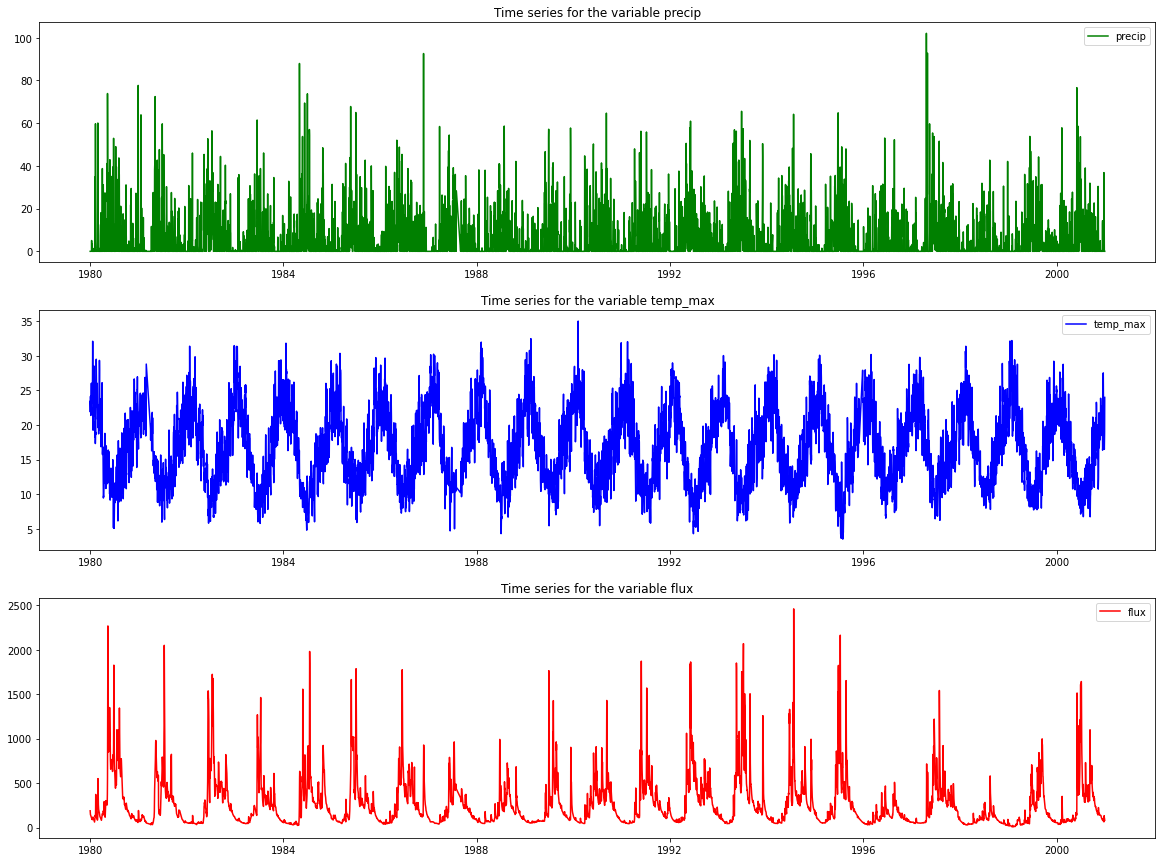

In [28]:
def plot_three_timeseries(cod_station, min_date, max_date, var1, var2, var3):
  df_filt = df[df.basin_id == cod_station][df.date >= min_date][df.date <= max_date]
  plt.figure(figsize=(20,15))
  plt.subplot(3,1,1)
  plt.plot(df_filt.date, df_filt[var1], 'g', label=var1)
  plt.title("Time series for the variable {}".format(var1))
  plt.legend()
  plt.subplot(3,1,2)
  plt.plot(df_filt.date, df_filt[var2], 'b', label=var2)
  plt.title("Time series for the variable {}".format(var2))
  plt.legend()
  plt.subplot(3,1,3)
  plt.plot(df_filt.date, df_filt[var3], 'r', label=var3)
  plt.title("Time series for the variable {}".format(var3))
  plt.legend()

plot_three_timeseries("9140001", "1980-01-01", "2000-12-30", "precip", "temp_max", "flux")

## Creating variables flux_extreme, temp_extreme and precip_extreme

Let's investigate the summer of 2000' temperatures in Chile

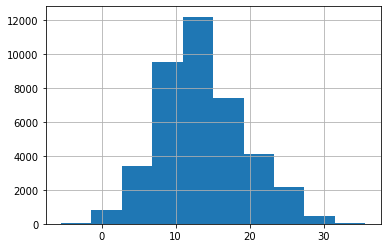

In [29]:
summer2000 = df_regions[df_regions.date > "1999-12-22"][df.date <= "2000-03-20"]
summer2000.temp_max.hist()

In [30]:
extreme_temp_2000 = np.percentile(summer2000.temp_max, 95)
extreme_temp_2000

24.255331252631574

If we would follow the approach to classify extreme climate events based on the 95th percentile of the season, for every day of the summer of 2000 in Chile, any temperature higher than 24.3 Celsius degrees would be considered an extreme temperature.

Another good way of determining if a variable is extreme is to take the sliding distribution for this variable 3 months to the past, in a given date. The variable could be considered extreme (value equal to 1) if its value is bigger than the 95th percentile for this 3 months sliding distribution.

#### flux_extreme

**!!! WARNING !!!: the following cell takes some minutes to run and its output is saved in the file flux_with_sliding_regions_flux.csv**

In [ ]:
'''df_extreme = df_regions.copy()

df_extreme_output_regions_flux = pd.DataFrame(columns=['region', 'date', 'flux', 'precip', 'temp_max', 'lat', 'lon', 'mean_elev', 'area_km2', 
                                                      'flux_sliding95percentile'])

for index, region in enumerate(df_regions.region.unique()):
  print("Processing {}th region named {}.".format(index, region))
  df_station_filt = df_extreme[df_extreme.region == region]
  flux_sliding95percentile = []
  # precip_sliding95percentile = []
  # temp_sliding95percentile = []
  for day in df_station_filt.date:
    min_day = day - datetime.timedelta(days=90)
    max_day = day
    df_station_filt_3months = df_station_filt[df_station_filt.date > min_day][df_station_filt.date <= max_day]
    percentile95_flux = np.percentile(df_station_filt_3months['flux'], 95)
    # percentile95_precip = np.percentile(df_station_filt_3months['precip'], 95)
    # percentile95_temp = np.percentile(df_station_filt_3months['temp_max'], 95)
    flux_sliding95percentile.append(percentile95_flux)
    # precip_sliding95percentile.append(percentile95_precip)
    # temp_sliding95percentile.append(percentile95_temp)

  df_station_filt['flux_sliding95percentile'] = flux_sliding95percentile
  # df_station_filt['precip_sliding95percentile'] = precip_sliding95percentile
  # df_station_filt['temp_sliding95percentile'] = temp_sliding95percentile
  df_extreme_output_regions_flux = pd.concat([df_extreme_output_regions_flux, df_station_filt], axis=0, ignore_index=True)
df_extreme_output_regions_flux.to_csv('flux_with_sliding_regions_flux.csv')'''

Processing 0th region named 1.
Processing 1th region named 2.
Processing 2th region named 3.
Processing 3th region named 4.
Processing 4th region named 5.
Processing 5th region named 6.
Processing 6th region named 7.
Processing 7th region named 8.
Processing 8th region named 9.
Processing 9th region named 10.
Processing 10th region named 11.
Processing 11th region named 12.


Creating flux_extreme variable:

In [31]:
df_flux = pd.read_csv('flux_with_sliding_regions_flux.csv')
df_flux.drop(columns=['Unnamed: 0'], inplace=True)
df_flux['flux_extreme'] = df_flux.apply(lambda x: int(x['flux'] >= x['flux_sliding95percentile'] and x['flux'] != 0), axis=1)
df_flux.head()

,region,date,flux,precip,temp_max,lat,lon,mean_elev,area_km2,flux_sliding95percentile,flux_extreme
0,1,1980-01-01,0.5616,0.0,11.345810,-19.05554,-69.126,4447.445505,324.888459,0.56160,1
1,1,1980-01-02,0.4748,0.0,12.137721,-19.05554,-69.126,4447.445505,324.888459,0.55726,0
2,1,1980-01-03,0.4016,0.0,12.221334,-19.05554,-69.126,4447.445505,324.888459,0.55292,0
3,1,1980-01-04,0.3610,0.0,13.022611,-19.05554,-69.126,4447.445505,324.888459,0.54858,0
4,1,1980-01-05,0.3372,0.0,13.119513,-19.05554,-69.126,4447.445505,324.888459,0.54424,0


#### precip_extreme

**!!! WARNING !!!: the following cell takes some minutes to run and its output is saved in the file flux_with_slidings_regions_precip.csv**

In [ ]:
'''df_extreme = df_regions.copy()

df_extreme_output_regions_precip = pd.DataFrame(columns=['region', 'date', 'flux', 'precip', 'temp_max', 'lat', 'lon', 'mean_elev', 'area_km2', 
                                                         'precip_sliding95percentile'])

for index, region in enumerate(df_regions.region.unique()):
  print("Processing {}th region named {}.".format(index, region))
  df_station_filt = df_extreme[df_extreme.region == region]
  precip_sliding95percentile = []
  # temp_sliding95percentile = []
  for day in df_station_filt.date:
    min_day = day - datetime.timedelta(days=90)
    max_day = day
    df_station_filt_3months = df_station_filt[df_station_filt.date > min_day][df_station_filt.date <= max_day]
    percentile95_precip = np.percentile(df_station_filt_3months['precip'], 95)
    # percentile95_temp = np.percentile(df_station_filt_3months['temp_max'], 95)
    precip_sliding95percentile.append(percentile95_precip)
    # temp_sliding95percentile.append(percentile95_temp)

  df_station_filt['precip_sliding95percentile'] = precip_sliding95percentile
  # df_station_filt['temp_sliding95percentile'] = temp_sliding95percentile
  df_extreme_output_regions_precip = pd.concat([df_extreme_output_regions_precip, df_station_filt], axis=0, ignore_index=True)
df_extreme_output_regions_precip.to_csv('flux_with_sliding_regions_precip.csv')'''

Processing 0th region named 1.
Processing 1th region named 2.
Processing 2th region named 3.
Processing 3th region named 4.
Processing 4th region named 5.
Processing 5th region named 6.
Processing 6th region named 7.
Processing 7th region named 8.
Processing 8th region named 9.
Processing 9th region named 10.
Processing 10th region named 11.
Processing 11th region named 12.


Creating precip_extreme variable:

In [32]:
df_precip = pd.read_csv('flux_with_sliding_regions_precip.csv')
df_precip.drop(columns=['Unnamed: 0'], inplace=True)
df_precip['precip_extreme'] = df_precip.apply(lambda x: int(x['precip'] >= x['precip_sliding95percentile'] and x['precip'] != 0), axis=1)
df_precip.head()

,region,date,flux,precip,temp_max,lat,lon,mean_elev,area_km2,precip_sliding95percentile,precip_extreme
0,1,1980-01-01,0.5616,0.0,11.345810,-19.05554,-69.126,4447.445505,324.888459,0.0,0
1,1,1980-01-02,0.4748,0.0,12.137721,-19.05554,-69.126,4447.445505,324.888459,0.0,0
2,1,1980-01-03,0.4016,0.0,12.221334,-19.05554,-69.126,4447.445505,324.888459,0.0,0
3,1,1980-01-04,0.3610,0.0,13.022611,-19.05554,-69.126,4447.445505,324.888459,0.0,0
4,1,1980-01-05,0.3372,0.0,13.119513,-19.05554,-69.126,4447.445505,324.888459,0.0,0


In [33]:
df_precip[df_precip.precip_extreme == 1]

,region,date,flux,precip,temp_max,lat,lon,mean_elev,area_km2,precip_sliding95percentile,precip_extreme
16,1,1980-01-17,0.21425,0.920236,12.960981,-19.320875,-69.09375,4396.155885,289.221519,0.184047,1
17,1,1980-01-18,0.20725,2.602819,13.132227,-19.320875,-69.09375,4396.155885,289.221519,1.172623,1
18,1,1980-01-19,0.20925,4.015939,12.573451,-19.320875,-69.09375,4396.155885,289.221519,2.744131,1
19,1,1980-01-20,0.24175,9.199207,12.386572,-19.320875,-69.09375,4396.155885,289.221519,4.275102,1
20,1,1980-01-21,0.24600,5.136118,11.440902,-19.320875,-69.09375,4396.155885,289.221519,5.136118,1
...,...,...,...,...,...,...,...,...,...,...,...
174753,12,2019-11-25,8.58550,9.022774,11.282957,-52.438050,-70.91790,339.293965,552.555265,5.986404,1
174765,12,2019-12-07,7.26250,6.846190,11.694980,-52.438050,-70.91790,339.293965,552.555265,6.241655,1
174766,12,2019-12-08,16.26250,7.859776,13.221253,-52.438050,-70.91790,339.293965,552.555265,6.614715,1
174774,12,2019-12-16,8.83900,8.557372,11.539262,-52.438050,-70.91790,339.293965,552.555265,7.298244,1


#### temp_extreme

**!!! WARNING !!!: the following cell takes some minutes to run and its output is saved in the file flux_with_sliding_regions_temp.csv**

In [ ]:
'''df_extreme = df_regions.copy()

df_extreme_output_regions_temp = pd.DataFrame(columns=['region', 'date', 'flux', 'precip', 'temp_max', 'lat', 'lon', 'mean_elev', 'area_km2', 
                                                       'temp_sliding95percentile'])

for index, region in enumerate(df_regions.region.unique()):
  print("Processing {}th region named {}.".format(index, region))
  df_station_filt = df_extreme[df_extreme.region == region]
  temp_sliding95percentile = []
  for day in df_station_filt.date:
    min_day = day - datetime.timedelta(days=90)
    max_day = day
    df_station_filt_3months = df_station_filt[df_station_filt.date > min_day][df_station_filt.date <= max_day]
    percentile95_temp = np.percentile(df_station_filt_3months['temp_max'], 95)
    temp_sliding95percentile.append(percentile95_temp)

  df_station_filt['temp_sliding95percentile'] = temp_sliding95percentile
  df_extreme_output_regions_temp = pd.concat([df_extreme_output_regions_temp, df_station_filt], axis=0, ignore_index=True)
df_extreme_output_regions_temp.to_csv('flux_with_sliding_regions_temp.csv')'''

Processing 0th region named 1.
Processing 1th region named 2.
Processing 2th region named 3.
Processing 3th region named 4.
Processing 4th region named 5.
Processing 5th region named 6.
Processing 6th region named 7.
Processing 7th region named 8.
Processing 8th region named 9.
Processing 9th region named 10.
Processing 10th region named 11.
Processing 11th region named 12.


Creating temp_extreme variable:

In [34]:
df_temp = pd.read_csv('flux_with_sliding_regions_temp.csv')
df_temp.drop(columns=['Unnamed: 0'], inplace=True)
df_temp['temp_extreme'] = df_temp.apply(lambda x: int(x['temp_max'] >= x['temp_sliding95percentile'] and x['temp_max'] != 0), axis=1)
df_temp.head()

,region,date,flux,precip,temp_max,lat,lon,mean_elev,area_km2,temp_sliding95percentile,temp_extreme
0,1,1980-01-01,0.5616,0.0,11.345810,-19.05554,-69.126,4447.445505,324.888459,11.345810,1
1,1,1980-01-02,0.4748,0.0,12.137721,-19.05554,-69.126,4447.445505,324.888459,12.098125,1
2,1,1980-01-03,0.4016,0.0,12.221334,-19.05554,-69.126,4447.445505,324.888459,12.212972,1
3,1,1980-01-04,0.3610,0.0,13.022611,-19.05554,-69.126,4447.445505,324.888459,12.902420,1
4,1,1980-01-05,0.3372,0.0,13.119513,-19.05554,-69.126,4447.445505,324.888459,13.100132,1


#### Merged dataframe for the model

- Since I have calculated the 95th percentile based in 3 months to the past of records, I am going to drop the first 3 months of records so that we follow the same estimative logic for all dates.
- I also dropped the records from the stations where we have missing data for some days, as a first approach. But a second approach, as mentioned, would be to fill this values using the mean value among the four nearest stations from the station where the value is missing, for the date being observed.

In [35]:
df_mg = pd.merge(df_flux, df_precip, on=['date', 'region', 'flux', 'precip', 'temp_max', 'lat', 'lon', 'mean_elev', 'area_km2'], how='outer')
df_mg = pd.merge(df_mg, df_temp, on=['date', 'region', 'flux', 'precip', 'temp_max', 'lat', 'lon', 'mean_elev', 'area_km2'], how='outer')
df_mg.head()

,region,date,flux,precip,temp_max,lat,lon,mean_elev,area_km2,flux_sliding95percentile,flux_extreme,precip_sliding95percentile,precip_extreme,temp_sliding95percentile,temp_extreme
0,1,1980-01-01,0.5616,0.0,11.345810,-19.05554,-69.126,4447.445505,324.888459,0.56160,1,0.0,0,11.345810,1
1,1,1980-01-02,0.4748,0.0,12.137721,-19.05554,-69.126,4447.445505,324.888459,0.55726,0,0.0,0,12.098125,1
2,1,1980-01-03,0.4016,0.0,12.221334,-19.05554,-69.126,4447.445505,324.888459,0.55292,0,0.0,0,12.212972,1
3,1,1980-01-04,0.3610,0.0,13.022611,-19.05554,-69.126,4447.445505,324.888459,0.54858,0,0.0,0,12.902420,1
4,1,1980-01-05,0.3372,0.0,13.119513,-19.05554,-69.126,4447.445505,324.888459,0.54424,0,0.0,0,13.100132,1


In [36]:
df_mg.isna().sum()

region                        0
date                          0
flux                          0
precip                        0
temp_max                      0
lat                           0
lon                           0
mean_elev                     0
area_km2                      0
flux_sliding95percentile      0
flux_extreme                  0
precip_sliding95percentile    0
precip_extreme                0
temp_sliding95percentile      0
temp_extreme                  0
dtype: int64

Dropping 3 first months of data:

In [37]:
df_mg_filt = df_mg.copy()
df_mg_filt = df_mg_filt[df_mg_filt.date >= "1980-03-01"]
df_mg_filt.reset_index(inplace=True)
df_mg_filt.drop(columns=['index'], inplace=True)

df_mg_filt.head()

,region,date,flux,precip,temp_max,lat,lon,mean_elev,area_km2,flux_sliding95percentile,flux_extreme,precip_sliding95percentile,precip_extreme,temp_sliding95percentile,temp_extreme
0,1,1980-03-01,0.18425,0.000000,11.327719,-19.320875,-69.09375,4396.155885,289.221519,0.36100,0,4.842429,0,13.601563,0
1,1,1980-03-02,0.18900,1.165040,12.370594,-19.320875,-69.09375,4396.155885,289.221519,0.35981,0,4.835048,0,13.597144,0
2,1,1980-03-03,0.20225,4.088189,10.106913,-19.320875,-69.09375,4396.155885,289.221519,0.35862,0,4.827666,0,13.592725,0
3,1,1980-03-04,0.22975,0.939100,9.590620,-19.320875,-69.09375,4396.155885,289.221519,0.35743,0,4.820285,0,13.588306,0
4,1,1980-03-05,0.22825,0.668703,9.759264,-19.320875,-69.09375,4396.155885,289.221519,0.35624,0,4.812903,0,13.583886,0


## Visualizing extreme variables

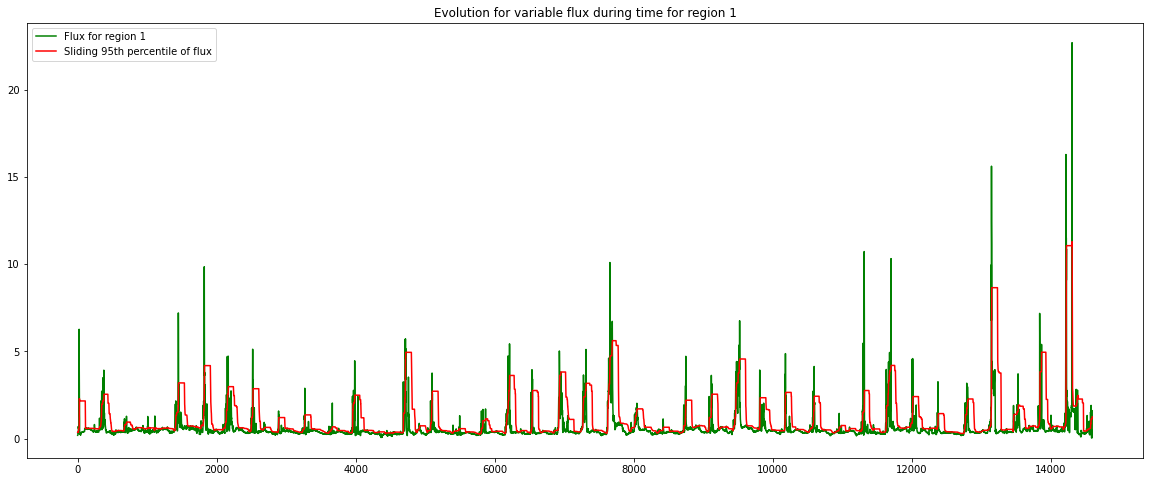

In [38]:
region1 = df_mg_filt[df_mg_filt.region == 1]
plt.figure(figsize=(20,8))
plt.plot(region1['flux'], 'g', label='Flux for region 1')
plt.plot(region1['flux_sliding95percentile'], 'r', label='Sliding 95th percentile of flux')
plt.title('Evolution for variable flux during time for region 1')
plt.legend()

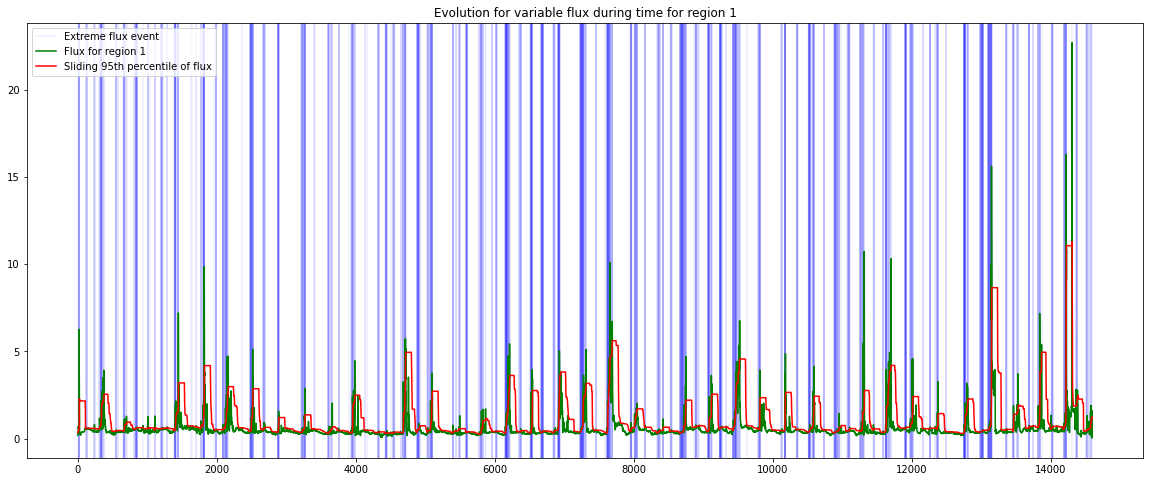

In [39]:
region1 = df_mg_filt[df_mg_filt.region == 1]
plt.figure(figsize=(20,8))
for index, line in enumerate(region1[region1.flux_extreme == 1].index):
  if index == 0:
    plt.axvline(line, color = 'b', label = 'Extreme flux event', linewidth=.1)
  else:
    plt.axvline(line, color = 'b', linewidth=.1)
plt.plot(region1['flux'], 'g', label='Flux for region 1')
plt.plot(region1['flux_sliding95percentile'], 'r', label='Sliding 95th percentile of flux')
plt.title('Evolution for variable flux during time for region 1')
plt.legend()

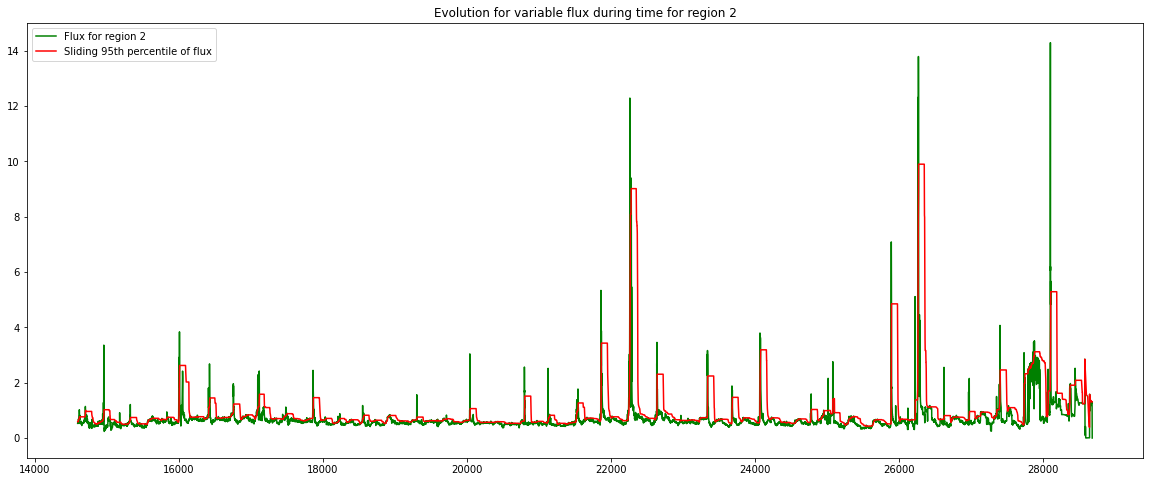

In [40]:
region2 = df_mg_filt[df_mg_filt.region == 2]
plt.figure(figsize=(20,8))
plt.plot(region2['flux'], 'g', label='Flux for region 2')
plt.plot(region2['flux_sliding95percentile'], 'r', label='Sliding 95th percentile of flux')
plt.title('Evolution for variable flux during time for region 2')
plt.legend()

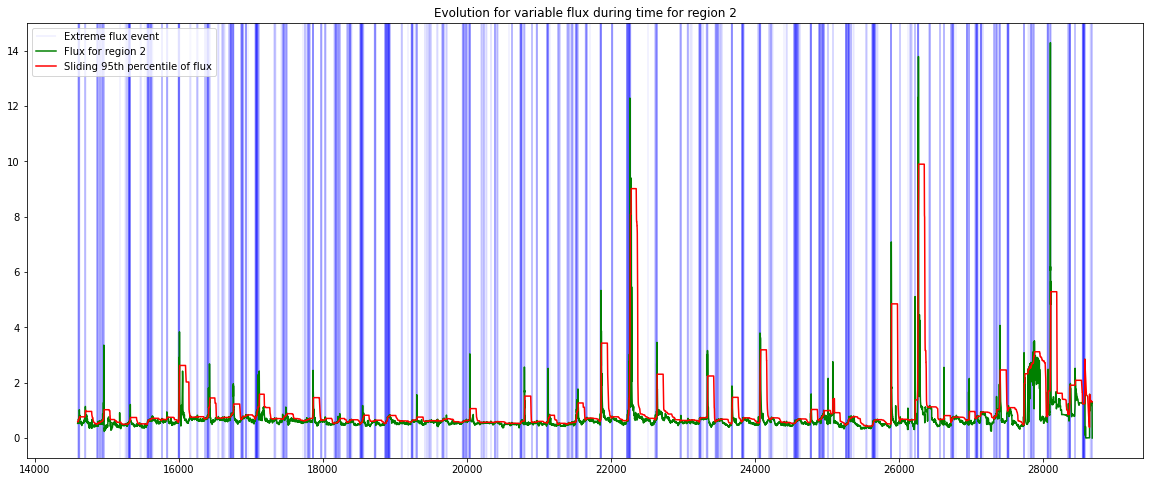

In [41]:
region2 = df_mg_filt[df_mg_filt.region == 2]
plt.figure(figsize=(20,8))
for index, line in enumerate(region2[region2.flux_extreme == 1].index):
  if index == 0:
    plt.axvline(line, color = 'b', label = 'Extreme flux event', linewidth=.1)
  else:
    plt.axvline(line, color = 'b', linewidth=.1)
plt.plot(region2['flux'], 'g', label='Flux for region 2')
plt.plot(region2['flux_sliding95percentile'], 'r', label='Sliding 95th percentile of flux')
plt.title('Evolution for variable flux during time for region 2')
plt.legend()

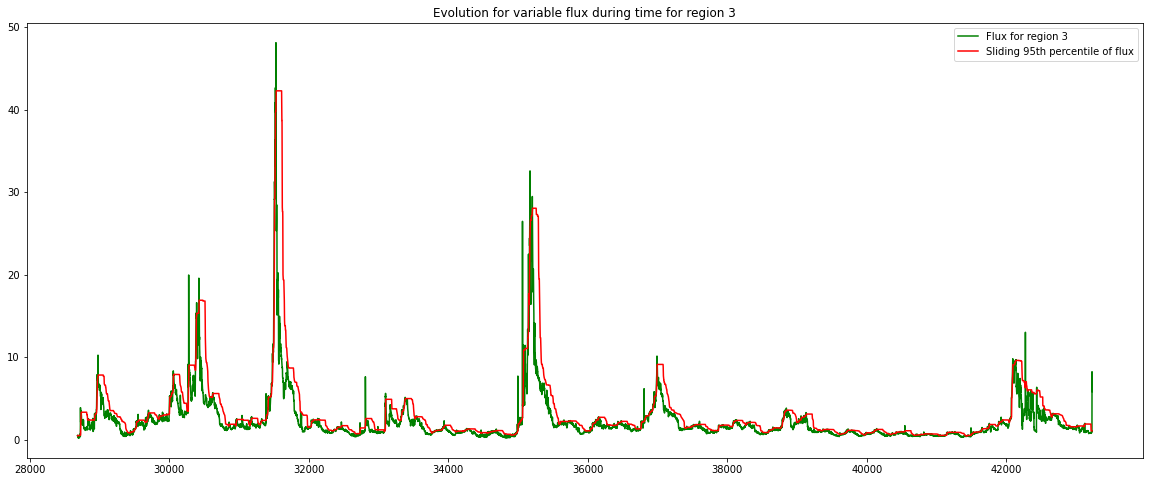

In [42]:
region3 = df_mg_filt[df_mg_filt.region == 3]
plt.figure(figsize=(20,8))
plt.plot(region3['flux'], 'g', label='Flux for region 3')
plt.plot(region3['flux_sliding95percentile'], 'r', label='Sliding 95th percentile of flux')
plt.title('Evolution for variable flux during time for region 3')
plt.legend()

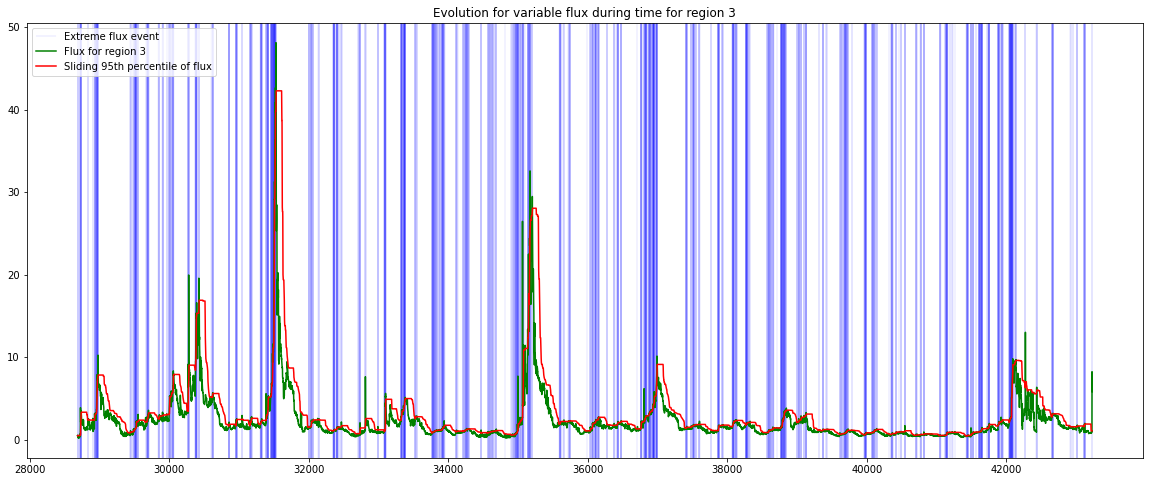

In [43]:
region3 = df_mg_filt[df_mg_filt.region == 3]
plt.figure(figsize=(20,8))
for index, line in enumerate(region3[region3.flux_extreme == 1].index):
  if index == 0:
    plt.axvline(line, color = 'b', label = 'Extreme flux event', linewidth=.1)
  else:
    plt.axvline(line, color = 'b', linewidth=.1)
plt.plot(region3['flux'], 'g', label='Flux for region 3')
plt.plot(region3['flux_sliding95percentile'], 'r', label='Sliding 95th percentile of flux')
plt.title('Evolution for variable flux during time for region 3')
plt.legend()

## Visualizing evolution of the extreme variables

In [44]:
df_mg_filt_evol = pd.DataFrame(columns=['date', 'region', 'flux', 'precip', 'temp_max', 'lat',
       'lon', 'mean_elev', 'area_km2', 'flux_sliding95percentile',
       'flux_extreme', 'precip_sliding95percentile', 'precip_extreme',
       'temp_sliding95percentile', 'temp_extreme', 'flux_extreme_abs_cumm',
       'flux_extreme_rel_cumm', 'precip_extreme_abs_cumm', 'precip_extreme_rel_cumm',
       'temp_extreme_abs_cumm', 'temp_extreme_rel_cumm'])

for region in df_mg_filt.region.unique():
  df_region_filt = df_mg_filt[df_mg_filt.region == region]
  sum_flux_extreme = df_region_filt.flux_extreme.sum()
  sum_precip_extreme = df_region_filt.precip_extreme.sum()
  sum_temp_extreme = df_region_filt.temp_extreme.sum()
  df_region_filt.sort_values(by='date')
  flux_extreme_abs_cumm = np.cumsum(df_region_filt.flux_extreme)
  flux_extreme_rel_cumm = flux_extreme_abs_cumm / sum_flux_extreme
  precip_extreme_abs_cumm = np.cumsum(df_region_filt.precip_extreme)
  precip_extreme_rel_cumm = precip_extreme_abs_cumm / sum_precip_extreme
  temp_extreme_abs_cumm = np.cumsum(df_region_filt.temp_extreme)
  temp_extreme_rel_cumm = temp_extreme_abs_cumm / sum_temp_extreme
  df_region_filt['flux_extreme_abs_cumm'] = flux_extreme_abs_cumm
  df_region_filt['flux_extreme_rel_cumm'] = flux_extreme_rel_cumm
  df_region_filt['precip_extreme_abs_cumm'] = precip_extreme_abs_cumm
  df_region_filt['precip_extreme_rel_cumm'] = precip_extreme_rel_cumm
  df_region_filt['temp_extreme_abs_cumm'] = temp_extreme_abs_cumm
  df_region_filt['temp_extreme_rel_cumm'] = temp_extreme_rel_cumm
  df_mg_filt_evol = pd.concat([df_mg_filt_evol, df_region_filt], axis=0)


df_mg_filt_evol

,date,region,flux,precip,temp_max,lat,lon,mean_elev,area_km2,flux_sliding95percentile,...,precip_sliding95percentile,precip_extreme,temp_sliding95percentile,temp_extreme,flux_extreme_abs_cumm,flux_extreme_rel_cumm,precip_extreme_abs_cumm,precip_extreme_rel_cumm,temp_extreme_abs_cumm,temp_extreme_rel_cumm
0,1980-03-01,1,0.18425,0.000000,11.327719,-19.320875,-69.09375,4396.155885,289.221519,0.36100,...,4.842429,0,13.601563,0,0,0.000000,0,0.0,0,0.0
1,1980-03-02,1,0.18900,1.165040,12.370594,-19.320875,-69.09375,4396.155885,289.221519,0.35981,...,4.835048,0,13.597144,0,0,0.000000,0,0.0,0,0.0
2,1980-03-03,1,0.20225,4.088189,10.106913,-19.320875,-69.09375,4396.155885,289.221519,0.35862,...,4.827666,0,13.592725,0,0,0.000000,0,0.0,0,0.0
3,1980-03-04,1,0.22975,0.939100,9.590620,-19.320875,-69.09375,4396.155885,289.221519,0.35743,...,4.820285,0,13.588306,0,0,0.000000,0,0.0,0,0.0
4,1980-03-05,1,0.22825,0.668703,9.759264,-19.320875,-69.09375,4396.155885,289.221519,0.35624,...,4.812903,0,13.583886,0,0,0.000000,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174157,2020-01-29,12,91.75300,4.250836,12.202825,-52.030000,-71.94140,414.643662,504.448138,91.75300,...,7.693343,0,16.488883,0,1257,0.996828,859,1.0,1712,1.0
174158,2020-01-30,12,91.75300,0.043187,13.102785,-52.030000,-71.94140,414.643662,504.448138,91.75300,...,7.693343,0,16.488883,0,1258,0.997621,859,1.0,1712,1.0
174159,2020-01-31,12,91.75300,3.921217,14.015178,-52.030000,-71.94140,414.643662,504.448138,91.75300,...,7.693343,0,16.488883,0,1259,0.998414,859,1.0,1712,1.0
174160,2020-02-01,12,91.75300,4.656228,14.260235,-52.030000,-71.94140,414.643662,504.448138,91.75300,...,7.693343,0,16.488883,0,1260,0.999207,859,1.0,1712,1.0


For region 1:

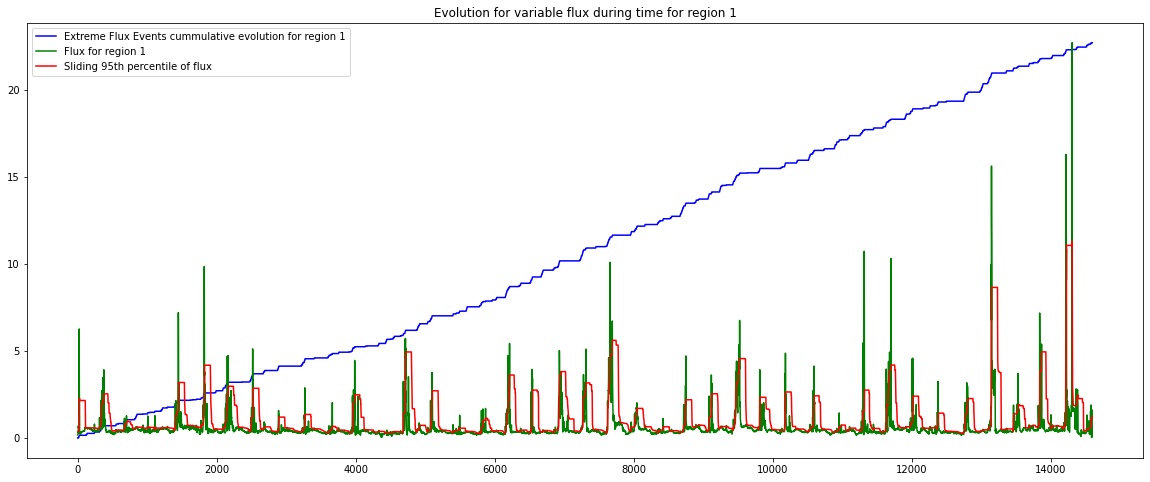

In [45]:
region1 = df_mg_filt_evol[df_mg_filt_evol.region == 1]
plt.figure(figsize=(20,8))
plt.plot(region1.index, region1['flux_extreme_rel_cumm']*max(region1.flux), 'b', label='Extreme Flux Events cummulative evolution for region 1')
plt.plot(region1['flux'], 'g', label='Flux for region 1')
plt.plot(region1['flux_sliding95percentile'], 'r', label='Sliding 95th percentile of flux')
plt.title('Evolution for variable flux during time for region 1')
plt.legend()

For region 2:

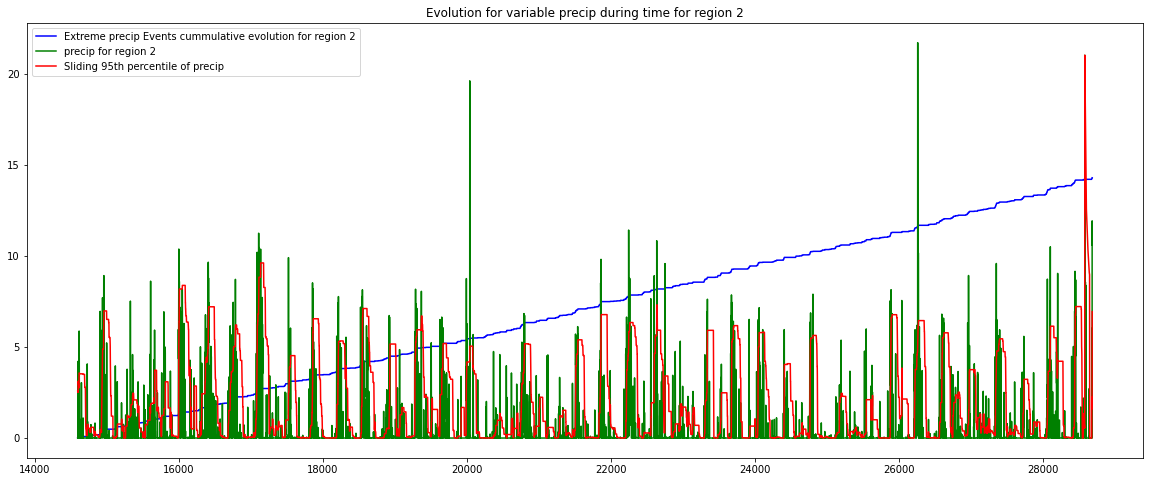

In [46]:
region2 = df_mg_filt_evol[df_mg_filt_evol.region == 2]
plt.figure(figsize=(20,8))
plt.plot(region2.index, region2['precip_extreme_rel_cumm']*max(region2.flux), 'b', label='Extreme precip Events cummulative evolution for region 2')
plt.plot(region2['precip'], 'g', label='precip for region 2')
plt.plot(region2['precip_sliding95percentile'], 'r', label='Sliding 95th percentile of precip')
plt.title('Evolution for variable precip during time for region 2')
plt.legend()

For region 3:

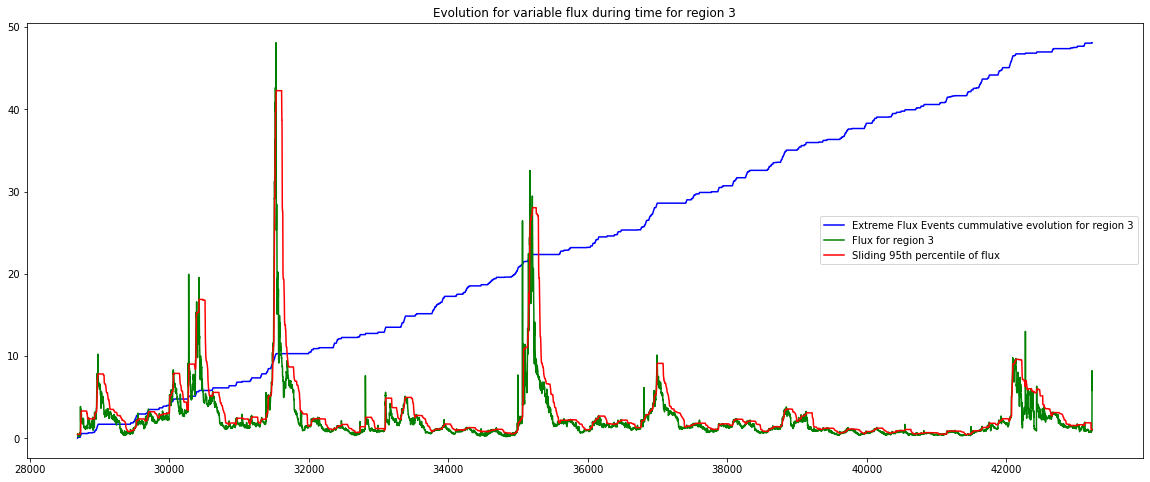

In [47]:
region3 = df_mg_filt_evol[df_mg_filt_evol.region == 3]
plt.figure(figsize=(20,8))
plt.plot(region3.index, region3['flux_extreme_rel_cumm']*max(region3.flux), 'b', label='Extreme Flux Events cummulative evolution for region 3')
plt.plot(region3['flux'], 'g', label='Flux for region 3')
plt.plot(region3['flux_sliding95percentile'], 'r', label='Sliding 95th percentile of flux')
plt.title('Evolution for variable flux during time for region 3')
plt.legend()

In [48]:
df_mg_filt_evol.columns

Index(['date', 'region', 'flux', 'precip', 'temp_max', 'lat', 'lon',
       'mean_elev', 'area_km2', 'flux_sliding95percentile', 'flux_extreme',
       'precip_sliding95percentile', 'precip_extreme',
       'temp_sliding95percentile', 'temp_extreme', 'flux_extreme_abs_cumm',
       'flux_extreme_rel_cumm', 'precip_extreme_abs_cumm',
       'precip_extreme_rel_cumm', 'temp_extreme_abs_cumm',
       'temp_extreme_rel_cumm'],
      dtype='object')

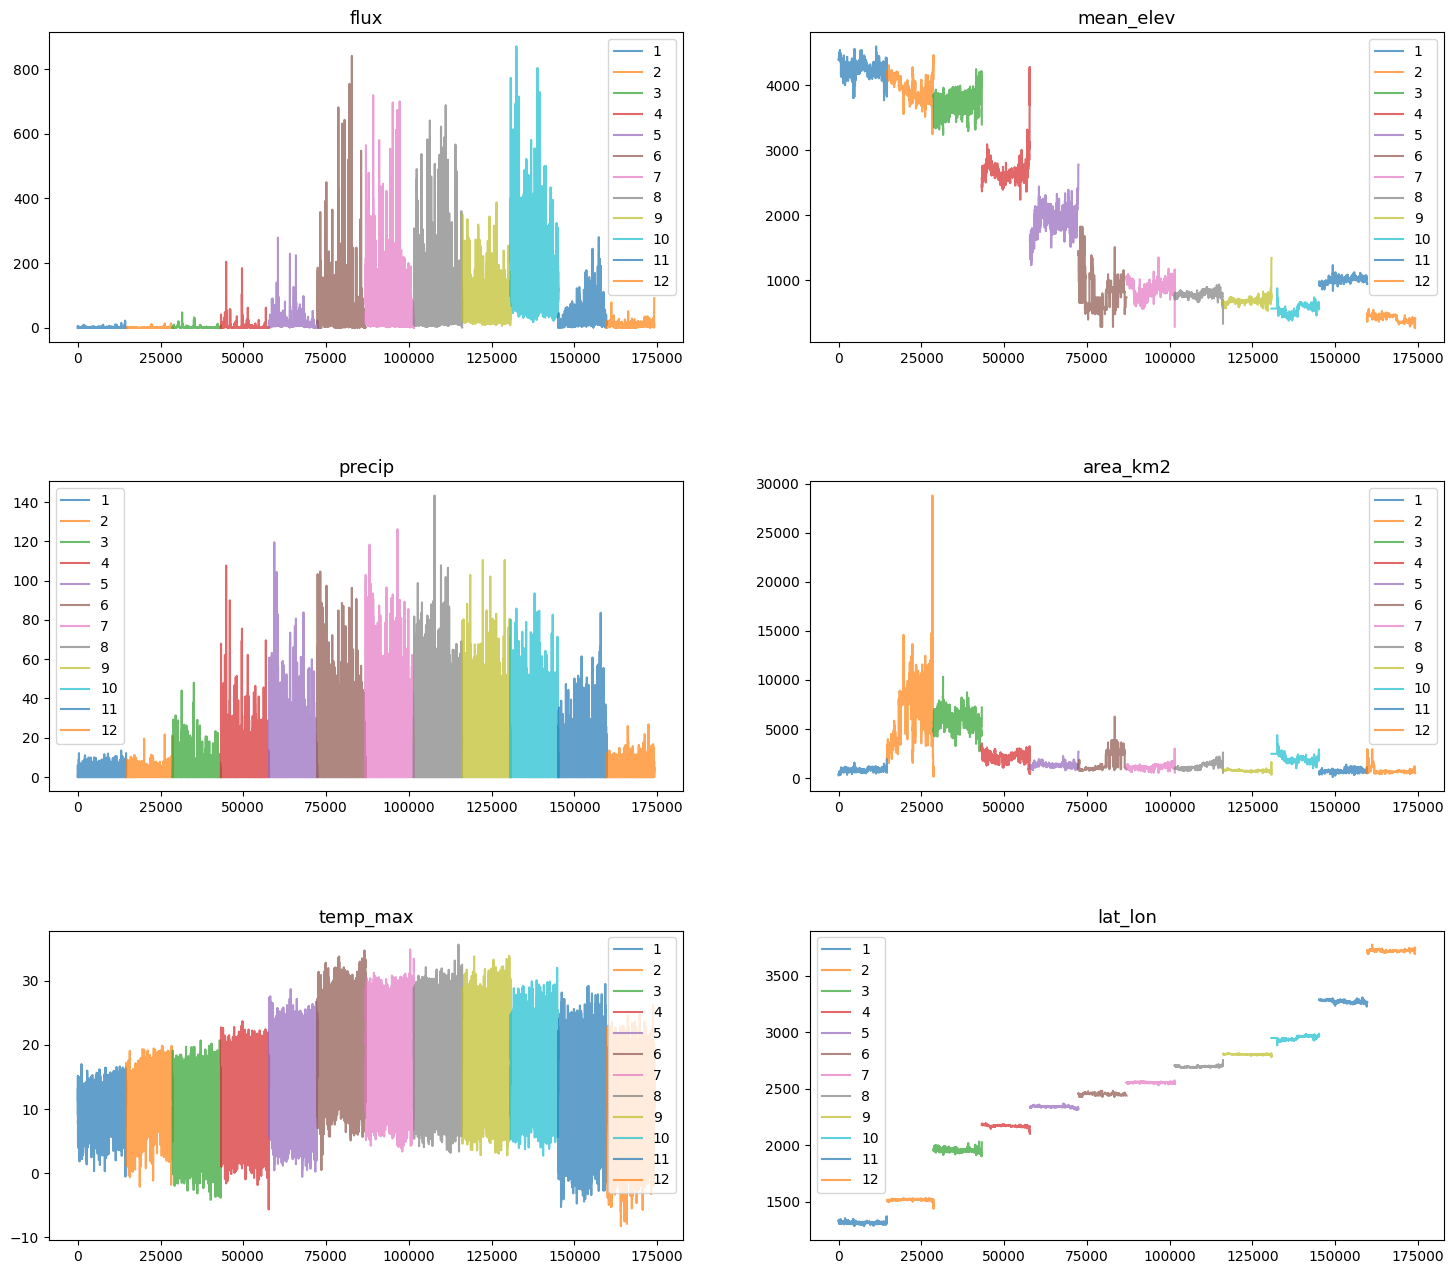

In [49]:
df_plot = df_mg_filt_evol[['date', 'region', 'flux', 'precip', 'temp_max', 'mean_elev', 'area_km2', 'lat', 'lon']]
df_plot['lat_lon'] = df_plot.apply(lambda x: x['lat'] * x['lon'], axis=1)
df_plot = df_plot[['date', 'region', 'flux', 'precip', 'temp_max', 'mean_elev', 'area_km2', 'lat_lon']]

fig, axes = plt.subplots(3,2,figsize=(18, 16), dpi=100)

for i, col_name in enumerate(df_plot.columns[2:]):
  if df_plot[col_name].dtype == 'O':
      df_plot.groupby('region')[col_name].hist(ax=axes[i%3][i//3], alpha=0.6);
      axes[i%3][i//3].legend(["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]);
  else:
      df_plot.groupby('region')[col_name].plot(ax=axes[i%3][i//3], alpha=0.7);
      axes[i%3][i//3].legend();
  axes[i%3][i//3].set_title(f'{col_name}', fontsize=13);
  plt.subplots_adjust(hspace=0.45)

# Model to predict extreme flux events

This is how I will frame the problem:
- This is going to be a classification model, so I will predict if whether or not there is going to be an extreme event in the future
- I will use historical data until the day before, to predict if an event is going to happen 3 days from the day we are. Three days seem like a reasonable trade-off between loosing precision for a date too far in the future and having time to prepare for an extreme event, if this model would be used by the government, for example.
- I will predict the extreme event in a national level, meaning that I will define a target variable based on the other 12 variables for each region. Therefore the flux_extreme_3days_future variable is going to be equal to 1 if:
  - We have a minimum of 4 regions with extreme flux events or
  - There are at least 2 regions adjacent to each other with extreme flux events
- To frame the features, I will pivot all variables to its own region, meaning every variable will have 12 columns of data, one for each of the regions.

## Preprocess

### Filtering by date

In [50]:
df_model = df_mg_filt_evol[['date', 'region', 'flux', 'precip', 'temp_max', 'lat', 'lon', 'mean_elev', 'area_km2', 'flux_extreme', 'precip_extreme', 'temp_extreme']]
for region in df_model.region.unique():
  df_filt_region = df_model[df_model.region == region]
  min_date_global = min(df_filt_region.date)
  max_date_global = max(df_filt_region.date)
  print("Region {} has data from {} to {}.".format(region, min_date_global, max_date_global))
  for variable in df_filt_region.columns:
    df_variable = df_filt_region[['date', variable]]
    min_date_variable = min(df_variable.date)
    max_date_variable = max(df_variable.date)
    print("Variable {} from region {} has data from {} to {}.". format(variable, region, min_date_variable, max_date_variable))
  print("\n")

Region 1 has data from 1980-03-01 to 2020-02-14.
Variable date from region 1 has data from date to date.
Variable region from region 1 has data from 1980-03-01 to 2020-02-14.
Variable flux from region 1 has data from 1980-03-01 to 2020-02-14.
Variable precip from region 1 has data from 1980-03-01 to 2020-02-14.
Variable temp_max from region 1 has data from 1980-03-01 to 2020-02-14.
Variable lat from region 1 has data from 1980-03-01 to 2020-02-14.
Variable lon from region 1 has data from 1980-03-01 to 2020-02-14.
Variable mean_elev from region 1 has data from 1980-03-01 to 2020-02-14.
Variable area_km2 from region 1 has data from 1980-03-01 to 2020-02-14.
Variable flux_extreme from region 1 has data from 1980-03-01 to 2020-02-14.
Variable precip_extreme from region 1 has data from 1980-03-01 to 2020-02-14.
Variable temp_extreme from region 1 has data from 1980-03-01 to 2020-02-14.


Region 2 has data from 1980-03-01 to 2020-01-21.
Variable date from region 2 has data from date to date.

Let's filter dates from the first to the last one available for all regions:

In [51]:
df_model_filt_date = df_model[df_model.date >= "1980-06-07"][df_model.date <= "2019-12-31"]
df_model_filt_date

,date,region,flux,precip,temp_max,lat,lon,mean_elev,area_km2,flux_extreme,precip_extreme,temp_extreme
98,1980-06-07,1,0.411333,0.000000,8.809551,-18.911883,-69.145967,4502.408959,333.423731,0,0,0
99,1980-06-08,1,0.408667,0.000000,8.826858,-18.911883,-69.145967,4502.408959,333.423731,0,0,0
100,1980-06-09,1,0.407833,0.000000,9.032550,-18.911883,-69.145967,4502.408959,333.423731,0,0,0
101,1980-06-10,1,0.578714,0.000000,9.895511,-18.834000,-69.253729,4433.107423,655.745309,0,0,0
102,1980-06-11,1,0.577286,0.000000,8.269594,-18.834000,-69.253729,4433.107423,655.745309,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
174125,2019-12-27,12,1.740000,2.875654,15.620208,-52.846100,-69.894400,263.944268,600.662393,0,0,1
174126,2019-12-28,12,46.816500,0.280907,14.774799,-52.438050,-70.917900,339.293965,552.555265,1,0,0
174127,2019-12-29,12,46.816500,0.000000,14.391673,-52.438050,-70.917900,339.293965,552.555265,1,0,0
174128,2019-12-30,12,46.731500,0.000000,12.900666,-52.438050,-70.917900,339.293965,552.555265,1,0,0


### Pivoting features

Let's pivot the dataframe so that every feature is divided in 12 new features, one for each region. This way, we will have a unique date by row of the dataframe.

In [52]:
df_model_pivot1 = df_model_filt_date[['date', 'region', 'flux', 'precip', 'temp_max', 'lat', 'lon', 'mean_elev', 'area_km2']]
df_model_pivot1 = df_model_pivot1.pivot_table(index=["date"], columns="region")
df_model_pivot1 = pd.DataFrame(df_model_pivot1.to_records())

df_model_pivot2 = df_model_filt_date[['date', 'region', 'flux_extreme', 'precip_extreme', 'temp_extreme']]
df_model_pivot2 = df_model_pivot2.pivot_table(index=["date"], columns="region")
df_model_pivot2 = pd.DataFrame(df_model_pivot2.to_records())

df_model_pivot = df_model_pivot1.merge(df_model_pivot2, on='date', how='inner')
df_model_pivot.head()

,date,"('area_km2', 1)","('area_km2', 2)","('area_km2', 3)","('area_km2', 4)","('area_km2', 5)","('area_km2', 6)","('area_km2', 7)","('area_km2', 8)","('area_km2', 9)",...,"('temp_extreme', 3)","('temp_extreme', 4)","('temp_extreme', 5)","('temp_extreme', 6)","('temp_extreme', 7)","('temp_extreme', 8)","('temp_extreme', 9)","('temp_extreme', 10)","('temp_extreme', 11)","('temp_extreme', 12)"
0,1980-06-07,333.423731,2034.577149,6287.517689,2563.977960,1324.894817,1468.976568,1274.720778,946.240531,801.598788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1980-06-08,333.423731,2034.577149,6287.517689,2563.977960,1274.532195,1468.976568,1274.720778,946.240531,801.598788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1980-06-09,333.423731,2034.577149,6287.517689,2563.977960,1274.532195,1468.976568,1274.720778,938.813276,801.598788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1980-06-10,655.745309,2034.577149,6287.517689,2563.977960,1324.894817,1468.976568,1274.720778,946.240531,801.598788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1980-06-11,655.745309,2034.577149,6287.517689,2609.950295,1252.438791,1468.976568,1274.720778,946.240531,801.598788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [53]:
def remove_special_char(col_name):
  col_name = col_name[2:-1]
  col_name = col_name.replace("', ", "_rg")
  return col_name

new_col_names = []
for col in df_model_pivot.columns:
  if col[0] == "(":
    new_col_name = remove_special_char(col)
  else:
    new_col_name = col
  new_col_names.append(new_col_name)

df_model_pivot.rename(columns=dict(zip(df_model_pivot.columns, new_col_names)), inplace=True)
df_model_pivot.head(3)

,date,area_km2_rg1,area_km2_rg2,area_km2_rg3,area_km2_rg4,area_km2_rg5,area_km2_rg6,area_km2_rg7,area_km2_rg8,area_km2_rg9,...,temp_extreme_rg3,temp_extreme_rg4,temp_extreme_rg5,temp_extreme_rg6,temp_extreme_rg7,temp_extreme_rg8,temp_extreme_rg9,temp_extreme_rg10,temp_extreme_rg11,temp_extreme_rg12
0,1980-06-07,333.423731,2034.577149,6287.517689,2563.97796,1324.894817,1468.976568,1274.720778,946.240531,801.598788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1980-06-08,333.423731,2034.577149,6287.517689,2563.97796,1274.532195,1468.976568,1274.720778,946.240531,801.598788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1980-06-09,333.423731,2034.577149,6287.517689,2563.97796,1274.532195,1468.976568,1274.720778,938.813276,801.598788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
df_model_pivot.shape

(14452, 121)

In [55]:
df_model_pivot.isna().sum().sort_values(ascending=False)

lon_rg2               459
flux_rg2              459
precip_extreme_rg2    459
mean_elev_rg2         459
lat_rg2               459
                     ... 
lon_rg12                0
lon_rg9                 0
lon_rg8                 0
lon_rg7                 0
temp_extreme_rg12       0
Length: 121, dtype: int64

Null values are now present because for some regions, we don't have data for all dates that are present for the other regions.

### Filling missing data from specific dates

In [56]:
df_model_pivot[df_model_pivot['temp_max_rg10'].isna() == True]

,date,area_km2_rg1,area_km2_rg2,area_km2_rg3,area_km2_rg4,area_km2_rg5,area_km2_rg6,area_km2_rg7,area_km2_rg8,area_km2_rg9,...,temp_extreme_rg3,temp_extreme_rg4,temp_extreme_rg5,temp_extreme_rg6,temp_extreme_rg7,temp_extreme_rg8,temp_extreme_rg9,temp_extreme_rg10,temp_extreme_rg11,temp_extreme_rg12
327,1981-04-30,687.810193,3217.801923,5266.504316,2286.409870,1072.949719,818.289109,1231.504307,1085.273146,801.598788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
328,1981-05-01,687.810193,3217.801923,5693.342898,2343.307243,1081.330503,818.289109,1231.504307,1024.706115,801.598788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
329,1981-05-02,687.810193,3217.801923,5693.342898,2343.307243,1081.330503,818.289109,1231.504307,1024.706115,801.598788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
330,1981-05-03,687.810193,3217.801923,5693.342898,2343.307243,1081.330503,818.289109,1231.504307,1024.706115,801.598788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
331,1981-05-04,687.810193,2999.186992,5693.342898,2343.307243,1212.159623,818.289109,1286.396757,1024.706115,801.598788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1744,1985-03-17,928.784005,4239.680989,5914.291575,2621.054910,1432.239124,818.289109,1134.928443,828.745744,872.374403,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
1745,1985-03-18,928.784005,4239.680989,5914.291575,2621.054910,1434.272135,818.289109,1134.928443,828.745744,872.374403,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
1746,1985-03-19,882.789452,4239.680989,5914.291575,2621.054910,1353.645131,818.289109,1134.928443,828.745744,872.374403,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
1747,1985-03-20,938.546852,4239.680989,5914.291575,2621.054910,1353.645131,818.289109,1134.928443,828.745744,872.374403,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0


How much of the whole does this missing data represent.

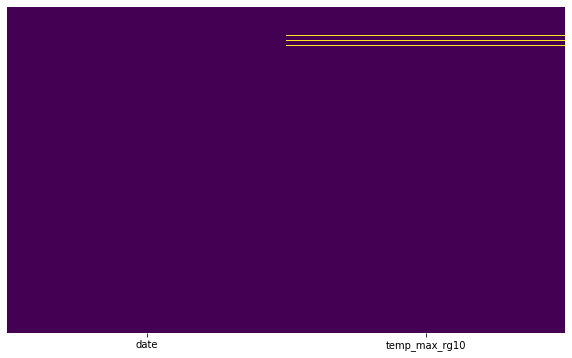

In [57]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_model_pivot[['date', 'temp_max_rg10']].isnull(), yticklabels=False, cmap='viridis', cbar=False);

Let's see how this data distribution looks like.

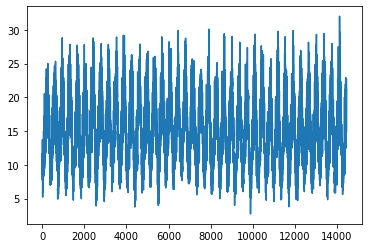

In [58]:
plt.plot(df_model_pivot['temp_max_rg10'])

Zooming in:

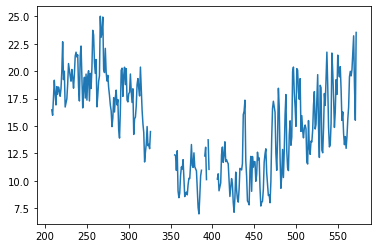

In [59]:
plt.plot(df_model_pivot[df_model_pivot.date >= "1981-01-01"][df_model_pivot.date <= "1981-12-31"]['temp_max_rg10'])

Let's write a function to fill the missing data with the average value for the feature being analyzed in the same day but in other years.

In [60]:
def fill_with_means(col_name):
  df_col_name = df_model_pivot[['date', col_name]]
  df_col_name = df_col_name[df_col_name[col_name].isna() == False]
  for date_null in df_model_pivot[df_model_pivot[col_name].isna() == True].date:
    day_null_datetime = datetime.datetime.strptime(date_null, '%Y-%m-%d').day
    month_null_datetime = datetime.datetime.strptime(date_null, '%Y-%m-%d').month
    list_of_days = []
    for date_notnull in df_model_pivot[df_model_pivot[col_name].isna() == False].date:
      day_notnull_datetime = datetime.datetime.strptime(date_notnull, '%Y-%m-%d').day
      month_notnull_datetime = datetime.datetime.strptime(date_notnull, '%Y-%m-%d').month
      if day_null_datetime == day_notnull_datetime and month_null_datetime == month_notnull_datetime:
        list_of_days.append(date_notnull)
    list_of_values = df_model_pivot[df_model_pivot.date.isin(list_of_days)][col_name].values
    avg_of_day = np.mean(list_of_values)
    df_mean = pd.DataFrame([{'date': date_null, col_name: avg_of_day}])
    df_col_name = pd.concat([df_col_name, df_mean], axis=0, ignore_index=True)
  df_col_name.sort_values(by='date', inplace=True)
  new_col_name = col_name + "_filled"
  df_col_name.rename(columns={col_name: new_col_name}, inplace=True)
  return new_col_name, df_col_name[new_col_name]

Let's fill the dataframe for all columns with missing data.

**!!! WARNING !!! The following cell takes more than 30 minutes to run and its output is in the file df_model_filled.csv**

In [ ]:
'''df_model_filled = df_model_pivot.copy()

missing_dict = dict(zip(df_model_pivot.columns, df_model_pivot.isna().sum()))
for col_name in missing_dict:
  print("Processing column {}".format(col_name))
  if missing_dict[col_name] != 0:
    new_col_name, new_values = fill_with_means(col_name)
    df_model_filled[new_col_name] = new_values
    df_model_filled.drop(columns=[col_name], inplace=True)
    df_model_filled.rename(columns={new_col_name: col_name}, inplace=True)

df_model_filled.to_csv('df_model_filled.csv')
df_model_filled'''

Processing column date
Processing column area_km2_rg1
Processing column area_km2_rg2
Processing column area_km2_rg3
Processing column area_km2_rg4
Processing column area_km2_rg5
Processing column area_km2_rg6
Processing column area_km2_rg7
Processing column area_km2_rg8
Processing column area_km2_rg9
Processing column area_km2_rg10
Processing column area_km2_rg11
Processing column area_km2_rg12
Processing column flux_rg1
Processing column flux_rg2
Processing column flux_rg3
Processing column flux_rg4
Processing column flux_rg5
Processing column flux_rg6
Processing column flux_rg7
Processing column flux_rg8
Processing column flux_rg9
Processing column flux_rg10
Processing column flux_rg11
Processing column flux_rg12
Processing column lat_rg1
Processing column lat_rg2
Processing column lat_rg3
Processing column lat_rg4
Processing column lat_rg5
Processing column lat_rg6
Processing column lat_rg7
Processing column lat_rg8
Processing column lat_rg9
Processing column lat_rg10
Processing col

,date,area_km2_rg1,area_km2_rg4,area_km2_rg5,area_km2_rg7,area_km2_rg8,area_km2_rg9,area_km2_rg12,flux_rg1,flux_rg4,...,precip_extreme_rg2,precip_extreme_rg3,precip_extreme_rg6,precip_extreme_rg10,precip_extreme_rg11,temp_extreme_rg2,temp_extreme_rg3,temp_extreme_rg6,temp_extreme_rg10,temp_extreme_rg11
0,1980-06-07,333.423731,2563.977960,1324.894817,1274.720778,946.240531,801.598788,499.957041,0.411333,2.709200,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1980-06-08,333.423731,2563.977960,1274.532195,1274.720778,946.240531,801.598788,2896.290938,0.408667,2.965850,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1980-06-09,333.423731,2563.977960,1274.532195,1274.720778,938.813276,801.598788,2896.290938,0.407833,3.198400,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1980-06-10,655.745309,2563.977960,1324.894817,1274.720778,946.240531,801.598788,2896.290938,0.578714,2.995650,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1980-06-11,655.745309,2609.950295,1252.438791,1274.720778,946.240531,801.598788,2896.290938,0.577286,3.127429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14447,2019-12-27,543.463920,557.962439,1368.173670,1614.410902,1639.473058,825.679383,600.662393,0.584000,1.410000,...,0.078947,0.102564,0.025641,0.026316,0.051282,0.236842,0.076923,0.282051,0.026316,0.307692
14448,2019-12-28,543.463920,557.962439,1368.173670,1614.410902,1639.473058,825.679383,552.555265,0.546000,1.410000,...,0.026316,0.051282,0.000000,0.026316,0.000000,0.210526,0.051282,0.307692,0.000000,0.256410
14449,2019-12-29,543.463920,557.962439,1368.173670,1614.410902,1639.473058,825.679383,552.555265,0.486500,1.410000,...,0.052632,0.000000,0.000000,0.026316,0.076923,0.131579,0.076923,0.307692,0.000000,0.333333
14450,2019-12-30,543.463920,557.962439,1368.173670,1614.410902,1639.473058,825.679383,552.555265,0.451500,1.410000,...,0.000000,0.025641,0.025641,0.026316,0.051282,0.105263,0.051282,0.230769,0.000000,0.230769


In [61]:
df_model_filled = pd.read_csv('df_model_filled.csv')
df_model_filled.drop(columns=['Unnamed: 0'], inplace=True)
df_model_filled.head()

,date,area_km2_rg1,area_km2_rg4,area_km2_rg5,area_km2_rg7,area_km2_rg8,area_km2_rg9,area_km2_rg12,flux_rg1,flux_rg4,...,precip_extreme_rg2,precip_extreme_rg3,precip_extreme_rg6,precip_extreme_rg10,precip_extreme_rg11,temp_extreme_rg2,temp_extreme_rg3,temp_extreme_rg6,temp_extreme_rg10,temp_extreme_rg11
0,1980-06-07,333.423731,2563.977960,1324.894817,1274.720778,946.240531,801.598788,499.957041,0.411333,2.709200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1980-06-08,333.423731,2563.977960,1274.532195,1274.720778,946.240531,801.598788,2896.290938,0.408667,2.965850,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1980-06-09,333.423731,2563.977960,1274.532195,1274.720778,938.813276,801.598788,2896.290938,0.407833,3.198400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1980-06-10,655.745309,2563.977960,1324.894817,1274.720778,946.240531,801.598788,2896.290938,0.578714,2.995650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1980-06-11,655.745309,2609.950295,1252.438791,1274.720778,946.240531,801.598788,2896.290938,0.577286,3.127429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
df_model_filled.precip_extreme_rg2.unique()

array([0.        , 1.        , 0.02702703, 0.08108108, 0.05405405,
       0.07894737, 0.05263158, 0.02631579, 0.10526316, 0.15789474,
       0.13157895, 0.18421053, 0.28947368, 0.05128205, 0.02564103,
       0.07692308, 0.12820513, 0.17948718, 0.15384615, 0.1025641 ,
       0.20512821, 0.25641026, 0.28205128, 0.30769231, 0.23076923,
       0.21052632, 0.34210526, 0.26315789, 0.39473684, 0.31578947,
       0.23684211, 0.46153846])

Let's round the categorical extreme variables to the nearest value between 0 and 1.

In [63]:
new_extreme_variables = {}
for col in df_model_filled.columns[1:]:
  if max(df_model_filled[col].values) <= 1 and min(df_model_filled[col].values) >= 0:
    list_of_new_values = []
    for value in df_model_filled[col].values:
      list_of_new_values.append(round(value, 0))
    new_extreme_variables[col] = list_of_new_values

df_model_filled_round = df_model_filled.copy()
df_model_filled_round.drop(columns=list(new_extreme_variables), inplace=True)
for key in new_extreme_variables:
  df_model_filled_round[key] = new_extreme_variables[key]
df_model_filled_round.columns

Index(['date', 'area_km2_rg1', 'area_km2_rg4', 'area_km2_rg5', 'area_km2_rg7',
       'area_km2_rg8', 'area_km2_rg9', 'area_km2_rg12', 'flux_rg1', 'flux_rg4',
       ...
       'precip_extreme_rg2', 'precip_extreme_rg3', 'precip_extreme_rg6',
       'precip_extreme_rg10', 'precip_extreme_rg11', 'temp_extreme_rg2',
       'temp_extreme_rg3', 'temp_extreme_rg6', 'temp_extreme_rg10',
       'temp_extreme_rg11'],
      dtype='object', length=121)

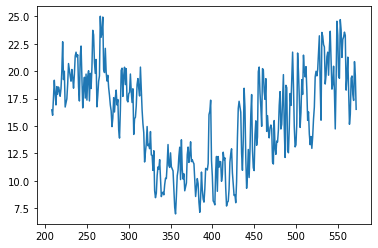

In [64]:
plt.plot(df_model_filled[df_model_filled.date >= "1981-01-01"][df_model_filled.date <= "1981-12-31"]['temp_max_rg10'])

### Creating target feature national_flux_extreme_3days_future

Let's create the national_flux_extreme variable.

In [65]:
df_model_target = df_model_filled.copy()

def check_if_national_event(*list_of_events):
  list_of_adjacent_events = []
  list_of_extreme_events = []
  list_of_regions_with_extreme_event = []
  for index, event in enumerate(list_of_events):
    if event == 1:
      list_of_extreme_events.append(event)
      list_of_regions_with_extreme_event.append(index+1)
  for region in list_of_regions_with_extreme_event:
    if region == 1 and region+1 in list_of_regions_with_extreme_event:
      list_of_adjacent_events.append(region)
    elif region-1 in list_of_regions_with_extreme_event or region+1 in list_of_regions_with_extreme_event:
      list_of_adjacent_events.append(region)
    elif region == 12 and region-1 in list_of_regions_with_extreme_event:
      list_of_adjacent_events.append(region)
  if len(list_of_extreme_events) >= 4 or len(list_of_adjacent_events) >= 2:
    national_flux_event = 1
  else:
    national_flux_event = 0
  return national_flux_event

df_model_target['national_flux_extreme'] = df_model_target.apply(lambda x: check_if_national_event(
         x['flux_extreme_rg1'], x['flux_extreme_rg2'], x['flux_extreme_rg3'], x['flux_extreme_rg4'], 
         x['flux_extreme_rg5'], x['flux_extreme_rg6'], x['flux_extreme_rg7'], x['flux_extreme_rg8'], 
         x['flux_extreme_rg9'], x['flux_extreme_rg10'], x['flux_extreme_rg11'], x['flux_extreme_rg12']), axis=1)
df_model_target

,date,area_km2_rg1,area_km2_rg4,area_km2_rg5,area_km2_rg7,area_km2_rg8,area_km2_rg9,area_km2_rg12,flux_rg1,flux_rg4,...,precip_extreme_rg3,precip_extreme_rg6,precip_extreme_rg10,precip_extreme_rg11,temp_extreme_rg2,temp_extreme_rg3,temp_extreme_rg6,temp_extreme_rg10,temp_extreme_rg11,national_flux_extreme
0,1980-06-07,333.423731,2563.977960,1324.894817,1274.720778,946.240531,801.598788,499.957041,0.411333,2.709200,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,1980-06-08,333.423731,2563.977960,1274.532195,1274.720778,946.240531,801.598788,2896.290938,0.408667,2.965850,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,1980-06-09,333.423731,2563.977960,1274.532195,1274.720778,938.813276,801.598788,2896.290938,0.407833,3.198400,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,1980-06-10,655.745309,2563.977960,1324.894817,1274.720778,946.240531,801.598788,2896.290938,0.578714,2.995650,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,1980-06-11,655.745309,2609.950295,1252.438791,1274.720778,946.240531,801.598788,2896.290938,0.577286,3.127429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14447,2019-12-27,543.463920,557.962439,1368.173670,1614.410902,1639.473058,825.679383,600.662393,0.584000,1.410000,...,0.102564,0.025641,0.026316,0.051282,0.236842,0.076923,0.282051,0.026316,0.307692,0
14448,2019-12-28,543.463920,557.962439,1368.173670,1614.410902,1639.473058,825.679383,552.555265,0.546000,1.410000,...,0.051282,0.000000,0.026316,0.000000,0.210526,0.051282,0.307692,0.000000,0.256410,0
14449,2019-12-29,543.463920,557.962439,1368.173670,1614.410902,1639.473058,825.679383,552.555265,0.486500,1.410000,...,0.000000,0.000000,0.026316,0.076923,0.131579,0.076923,0.307692,0.000000,0.333333,0
14450,2019-12-30,543.463920,557.962439,1368.173670,1614.410902,1639.473058,825.679383,552.555265,0.451500,1.410000,...,0.025641,0.025641,0.026316,0.051282,0.105263,0.051282,0.230769,0.000000,0.230769,0


Now let's create the national_flux_extreme_3days_future variable.

In [66]:
def extreme_flux_in_3days(index):
  if index+3 <= max(df_model_target.index) and index-3 >= min(df_model_target.index):
    return df_model_target.iloc[index+3].national_flux_extreme
  else:
    return 0

df_model_target['col_index'] = df_model_target.index

df_model_target['national_flux_extreme_3days_future'] = df_model_target.col_index.apply(extreme_flux_in_3days)
df_model_target.drop(columns=['col_index'], inplace=True)
df_model_target

,date,area_km2_rg1,area_km2_rg4,area_km2_rg5,area_km2_rg7,area_km2_rg8,area_km2_rg9,area_km2_rg12,flux_rg1,flux_rg4,...,precip_extreme_rg6,precip_extreme_rg10,precip_extreme_rg11,temp_extreme_rg2,temp_extreme_rg3,temp_extreme_rg6,temp_extreme_rg10,temp_extreme_rg11,national_flux_extreme,national_flux_extreme_3days_future
0,1980-06-07,333.423731,2563.977960,1324.894817,1274.720778,946.240531,801.598788,499.957041,0.411333,2.709200,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
1,1980-06-08,333.423731,2563.977960,1274.532195,1274.720778,946.240531,801.598788,2896.290938,0.408667,2.965850,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
2,1980-06-09,333.423731,2563.977960,1274.532195,1274.720778,938.813276,801.598788,2896.290938,0.407833,3.198400,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
3,1980-06-10,655.745309,2563.977960,1324.894817,1274.720778,946.240531,801.598788,2896.290938,0.578714,2.995650,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
4,1980-06-11,655.745309,2609.950295,1252.438791,1274.720778,946.240531,801.598788,2896.290938,0.577286,3.127429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14447,2019-12-27,543.463920,557.962439,1368.173670,1614.410902,1639.473058,825.679383,600.662393,0.584000,1.410000,...,0.025641,0.026316,0.051282,0.236842,0.076923,0.282051,0.026316,0.307692,0,0
14448,2019-12-28,543.463920,557.962439,1368.173670,1614.410902,1639.473058,825.679383,552.555265,0.546000,1.410000,...,0.000000,0.026316,0.000000,0.210526,0.051282,0.307692,0.000000,0.256410,0,0
14449,2019-12-29,543.463920,557.962439,1368.173670,1614.410902,1639.473058,825.679383,552.555265,0.486500,1.410000,...,0.000000,0.026316,0.076923,0.131579,0.076923,0.307692,0.000000,0.333333,0,0
14450,2019-12-30,543.463920,557.962439,1368.173670,1614.410902,1639.473058,825.679383,552.555265,0.451500,1.410000,...,0.025641,0.026316,0.051282,0.105263,0.051282,0.230769,0.000000,0.230769,0,0


In [67]:
df_model_target.national_flux_extreme_3days_future.value_counts(normalize=True)

0    0.83158
1    0.16842
Name: national_flux_extreme_3days_future, dtype: float64

We have a very inbalanced target variable distribution.

### Splitting the data

In [69]:
X = df_model_target.drop(columns=['date', 'national_flux_extreme', 'national_flux_extreme_3days_future'])
y = df_model_target.national_flux_extreme_3days_future

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

In [70]:
y_train.value_counts(normalize=True)

0    0.831554
1    0.168446
Name: national_flux_extreme_3days_future, dtype: float64

In [71]:
y_test.value_counts(normalize=True)

0    0.831642
1    0.168358
Name: national_flux_extreme_3days_future, dtype: float64

## Decision Tree

As a basal model, let's train a decision tree without any variable scalling and transformation and see how the model performs. After that, we can use Boruta model selection function to choose the best 3 models to fit this data.

A high precision would make our model very good at predicting an extreme event with confidence that it would really happen. A high recall would make our model very good at predicting all events that could be extreme, even if ths prediction is incorrect.
The chosen metric to evaluate the model and perform grid searches is the recall, because it is more valuable to predict all extreme events and make a mistake than not to predict this event. From a government poin of view, the cost of the second situation is much higher than the cost of the first one.

In [72]:
decision_tree = DecisionTreeClassifier(random_state=123)
decision_tree.fit(X_train,y_train)

DecisionTreeClassifier(random_state=123)

In [73]:
decision_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 123,
 'splitter': 'best'}

In [74]:
y_train_pred_decision_tree = decision_tree.predict(X_train)
y_test_pred_decision_tree = decision_tree.predict(X_test)

print("Precision score is {}".format(precision_score(y_test, y_test_pred_decision_tree)))
print("Recall score is {}".format(recall_score(y_test, y_test_pred_decision_tree)))
print("F1 Score score is {}".format(f1_score(y_test, y_test_pred_decision_tree)))
print("Accuracy score is {}".format(accuracy_score(y_test, y_test_pred_decision_tree)))

Precision score is 0.45525291828793774
Recall score is 0.4808219178082192
F1 Score score is 0.4676882078614257
Accuracy score is 0.8157287822878229


As expected, the first basal model performed pretty poorly. Let's tune the hyperparameters to see if we can boost the metrics a little.

### Tuning

In [75]:
parameters={"splitter":["best","random"],
             "max_depth" : [1,3,5,7,9],
             "min_samples_leaf":[1,3,5,7,10],
             "max_features":["auto","log2","sqrt"],
             "max_leaf_nodes":[5, 10,15] }

tuning_decision_tree = GridSearchCV(decision_tree,param_grid=parameters,scoring='recall',cv=10,verbose=3)
tuning_decision_tree.fit(X_train,y_train)

Fitting 10 folds for each of 450 candidates, totalling 4500 fits
[CV 1/10] END max_depth=1, max_features=auto, max_leaf_nodes=5, min_samples_leaf=1, splitter=best;, score=0.000 total time=   0.0s
[CV 2/10] END max_depth=1, max_features=auto, max_leaf_nodes=5, min_samples_leaf=1, splitter=best;, score=0.000 total time=   0.0s
[CV 3/10] END max_depth=1, max_features=auto, max_leaf_nodes=5, min_samples_leaf=1, splitter=best;, score=0.000 total time=   0.0s
[CV 4/10] END max_depth=1, max_features=auto, max_leaf_nodes=5, min_samples_leaf=1, splitter=best;, score=0.000 total time=   0.0s
[CV 5/10] END max_depth=1, max_features=auto, max_leaf_nodes=5, min_samples_leaf=1, splitter=best;, score=0.000 total time=   0.0s
[CV 6/10] END max_depth=1, max_features=auto, max_leaf_nodes=5, min_samples_leaf=1, splitter=best;, score=0.000 total time=   0.0s
[CV 7/10] END max_depth=1, max_features=auto, max_leaf_nodes=5, min_samples_leaf=1, splitter=best;, score=0.000 total time=   0.0s
[CV 8/10] END max_

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=123),
             param_grid={'max_depth': [1, 3, 5, 7, 9],
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'max_leaf_nodes': [5, 10, 15],
                         'min_samples_leaf': [1, 3, 5, 7, 10],
                         'splitter': ['best', 'random']},
             scoring='recall', verbose=3)

In [76]:
tuning_decision_tree.best_params_

{'max_depth': 5,
 'max_features': 'log2',
 'max_leaf_nodes': 15,
 'min_samples_leaf': 5,
 'splitter': 'random'}

In [77]:
tuning_decision_tree.best_score_

0.21249742002063982

In [78]:
tuning_decision_tree = DecisionTreeClassifier(max_depth= 5,
                                              max_features = 'log2',
                                              max_leaf_nodes= 15,
                                              min_samples_leaf= 5,
                                              splitter = 'random')
tuning_decision_tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5, max_features='log2', max_leaf_nodes=15,
                       min_samples_leaf=5, splitter='random')

In [79]:
y_train_pred_tuning_decision_tree = tuning_decision_tree.predict(X_train)
y_test_pred_tuning_decision_tree = tuning_decision_tree.predict(X_test)

print("Precision score is {}".format(precision_score(y_test, y_test_pred_tuning_decision_tree)))
print("Recall score is {}".format(recall_score(y_test, y_test_pred_tuning_decision_tree)))
print("F1 Score score is {}".format(f1_score(y_test, y_test_pred_tuning_decision_tree)))
print("Accuracy score is {}".format(accuracy_score(y_test, y_test_pred_tuning_decision_tree)))

Precision score is 0.63
Recall score is 0.0863013698630137
F1 Score score is 0.15180722891566267
Accuracy score is 0.8376383763837638


## Random Forest

In [80]:
random_forest = RandomForestClassifier(random_state=123)
random_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

In [81]:
random_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [82]:
y_train_pred_random_forest = random_forest.predict(X_train)
y_test_pred_random_forest = random_forest.predict(X_test)

print("Precision score is {}".format(precision_score(y_test, y_test_pred_random_forest)))
print("Recall score is {}".format(recall_score(y_test, y_test_pred_random_forest)))
print("F1 Score score is {}".format(f1_score(y_test, y_test_pred_random_forest)))
print("Accuracy score is {}".format(accuracy_score(y_test, y_test_pred_random_forest)))

Precision score is 0.7692307692307693
Recall score is 0.3698630136986301
F1 Score score is 0.49953746530989823
Accuracy score is 0.8752306273062731


### Tuning

In [83]:
parameters={"criterion":["gini", "entropy", "log_loss"],
             "max_depth" : [1,3,5,7,9],
             "min_samples_leaf":[1,3,5,7,10],
             "max_features":["auto","log2","sqrt"],
             "max_leaf_nodes":[5, 10,15] }

tuning_random_forest = GridSearchCV(random_forest,param_grid=parameters,scoring='recall',cv=10,verbose=3)
tuning_random_forest.fit(X_train,y_train)

Streaming output truncated to the last 5000 lines.
[CV 1/10] END criterion=gini, max_depth=7, max_features=sqrt, max_leaf_nodes=15, min_samples_leaf=1;, score=0.106 total time=   2.3s
[CV 2/10] END criterion=gini, max_depth=7, max_features=sqrt, max_leaf_nodes=15, min_samples_leaf=1;, score=0.112 total time=   2.4s
[CV 3/10] END criterion=gini, max_depth=7, max_features=sqrt, max_leaf_nodes=15, min_samples_leaf=1;, score=0.099 total time=   2.4s
[CV 4/10] END criterion=gini, max_depth=7, max_features=sqrt, max_leaf_nodes=15, min_samples_leaf=1;, score=0.094 total time=   2.3s
[CV 5/10] END criterion=gini, max_depth=7, max_features=sqrt, max_leaf_nodes=15, min_samples_leaf=1;, score=0.123 total time=   2.4s
[CV 6/10] END criterion=gini, max_depth=7, max_features=sqrt, max_leaf_nodes=15, min_samples_leaf=1;, score=0.146 total time=   2.3s
[CV 7/10] END criterion=gini, max_depth=7, max_features=sqrt, max_leaf_nodes=15, min_samples_leaf=1;, score=0.129 total time=   2.4s
[CV 8/10] END crit

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=123),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [1, 3, 5, 7, 9],
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'max_leaf_nodes': [5, 10, 15],
                         'min_samples_leaf': [1, 3, 5, 7, 10]},
             scoring='recall', verbose=3)

In [84]:
tuning_random_forest.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'auto',
 'max_leaf_nodes': 15,
 'min_samples_leaf': 5}

In [85]:
tuning_random_forest.best_score_

0.11737530099759201

In [86]:
tuning_random_forest = RandomForestClassifier(max_depth= 7,
                                              max_features = 'auto',
                                              max_leaf_nodes= 15,
                                              min_samples_leaf= 5,
                                              criterion = 'gini')
tuning_random_forest.fit(X_train,y_train)

RandomForestClassifier(max_depth=7, max_leaf_nodes=15, min_samples_leaf=5)

In [87]:
y_train_pred_tuning_random_forest = tuning_random_forest.predict(X_train)
y_test_pred_tuning_random_forest = tuning_random_forest.predict(X_test)

print("Precision score is {}".format(precision_score(y_test, y_test_pred_tuning_random_forest)))
print("Recall score is {}".format(recall_score(y_test, y_test_pred_tuning_random_forest)))
print("F1 Score score is {}".format(f1_score(y_test, y_test_pred_tuning_random_forest)))
print("Accuracy score is {}".format(accuracy_score(y_test, y_test_pred_tuning_random_forest)))

Precision score is 0.7916666666666666
Recall score is 0.10410958904109589
F1 Score score is 0.18401937046004843
Accuracy score is 0.8445571955719557


# Final considerations

- The performance of the models were not good for the recall score, even though the random forest brought an acceptable precision score.This means that this model is good at predicting correctly the extreme events but not that good at predicting all extreme events that will happen. To find better models, we could use Boruta model selection to train some other models and rank them by recall score
- In addition to a national model predicting extreme events, we could train also regional models, to predict extreme events inside each region, using only the variables for that region to train the model. Because the features' distributions follow a more similar trend inside a region, I would expect a higher precision and recall for the same models
- To include time variability for each feature, we could also add one or two lag columns, each one bringing the feature's values for the last day and the day before
- Instead of a classification model, we could train regression models or time series to predict the next value of the variable flux, and having that, we could categorize it in extreme or not. In this case, the framing of the model would be totally different, starting by the split of the data, that would be done by date